# MLB Win Expectancy Win and Probability Added, Part I

*The information used here was obtained free of charge from and is copyrighted by Retrosheet. Interested parties may contact Retrosheet at "www.retrosheet.org".*

## 1. Introduction

## 1.1 Baseball Reference Win Expectancy and Win Probability Added

Baseball Reference offers two statistics, win expectancy and win probability added, that directly measure how each event in a Major League Baseball (MLB) game contribute to the outcome.
A baseball game can be reduced to a relatively small number of discrete events. Win expectancy (WE) is the probability of a team winning for a given score differential, base-out situation, and inning, i.e., game state. WE can identify important game-states and inform managers and general managers on strategy, roster construction, etc. The Baseball Reference procedure for calculating WE has three primary components:
1.	Calculate the score differential prior to each event of record. The maximum score differential is 11 runs; any lead (by either team) is treated as a score differential of +/- 11 runs.
2.	Apply adjustments to the score differential to account for the run scoring context. The run scoring context is affected by the season and the park where the game is played. Baseball Reference estimates the season and park factors by simulating a series of run scoring environments.
3.	Calculate the *a priori* WE for each game state. Extra innings are treated as repetitions of the 9th inning.
Baseball Reference offers a full description of their methodology here: https://www.baseball-reference.com/about/wpa.shtml. It is essentially a Bayesian model with minor transformations to the feature set.
By comparing the change in WE before and after an event, we can calculate win probability added (WPA). WPA is assigned to a player or players most responsible for the result in the play, i.e., the change in the WE due to the change in the game state. A positive WPA value means that a player has increased their team's probability of a win; a negative WPA indicates a player decreased their team's probability of a win. WPA is typically assigned to completely to the batter and the pitcher. Baserunners are not credited with WPA except for events where the batter makes no play: stolen bases, caught stealing, wild pitches, passed balls, etc. Fielders are not credited with WPA at all. See the link above for more details.

WPA does not reward a player for "stat padding", so it is a useful tool for measuring a player’s impact on team performance. Let’s suppose, for example, a batter hits a double with 2 outs in the top of the 9th inning when his team is losing by 10 runs. A double is, in most circumstances, a positive event for the batting team. In this case, however, the event will not likely change the outcome of the game, so the batter is credited with a WPA at or near zero. Likewise, WPA does not punish players who fail in circumstances where the outcome is virtually decided. This concept is called leverage. Leverage is a function of score differential and base-out situations. High leverage situations occur when the outcome of the game is materially affected by the preceding/succeeding event. Given a large enough sample size, a player's WPA should correlate to their oWAR (for batters and baserunners).



## 2. Motivation

In this project, we will attempt to recreate the Baseball Reference WPA/WE results using a variety of regression and classification algorithms. This is primarily a proof of concept: we will simplify the procedure for estimating park and season factors, identify which algorithms produce feasible results, identify strengths and weakness of the resulting models, and suggest improvements for a follow up project.

## 3. ETL





### 3.1 Data Set
Our data set consists of more 164,000 regular-season games and twelve million events from the 1920 season through the 2022 season. The unmodified features in the data set are as follows:

- *home_team*: 3-charachter code identifying the home team.
- *vis_team*: 3-charachter code identifying the visiting team.
- *season*: integer value for the season during which the game is played.
- *park*: 5-digit alphanumeric code for the park where the game is played.
- *game_id*: 12-digit alphanumeric code that uniquely identifies the game.
- *event_id*: integer that uniquely each event in a game.
- *batting_team*: boolean integer that indicates if the home team is batting
  - 'f'=false
  - 't'=true
- *inning*: integer that represents the inning in which the event takes place.
- *outs*: integer that represents the number of outs prior to the event of record.
- *vis_score*: integer that represents the visiting team score prior to the event of record.
- *home_score*: integer that represents the home team score prior the event of record.
- *result_pitcher_id*: 8-digit alphanumeric code that uniquely identfies the pitcher for the event of record.
- *result_batter_hand*: 8-digit alphanumeric code that uniquely identfies the batter for the event of record.
 - 'l' = left
 - 'r' = right
- *result_pitcher_hand*: 1-digit code that indicates the throwing hand of the result pitcher id.
- *run_1b*: 8-digit alphanumeric code that uniquely identfies the runner of on first base, if any.

- *run_2b*: 8-digit alphanumeric code that uniquely identfies the runner of on second base, if any.

- *run_3b*: 8-digit alphanumeric code that uniquely identfies the runner of on third base, if any.

- *leadoff*: boolean value indicating if the event of record is the first of the inning.
 - 'f'=false
 - 't'=true
- *pinch_hit*: boolean value indicating if the result batter is a pinch hitter for the event of record.
 - 'f'=false
 - 't'=true
- *batt_lineup_pos*: integer representing the order in which the result batter appears in the lineup.

- *start_game*: boolean value indicating that the event of record is the first event of the game.
 - 'f'=false
 - 't'=true
- *end_game*: boolean value indicating that the event of record is the last event of the game.
 - 'f'=false
 - 't'=true
- *pinch_run_1b*: 8-digit alphanumeric code that uniquely identifies the pinch-runner on first base, if present.

- *pinch_run_2b*: 8-digit alphanumeric code that uniquely identifies the pinch-runner on second base, if present.

- *pinch_run_3b*: 8-digit alphanumeric code that uniquely identifies the pinch-runner on third base, if present.

The source of the training, testing, and validation data is Retrosheet which notes that data coverage prior to 1973 is incomplete.

### 3.2 Transformations

According to the procedure described by Baseball reference, we make the following transformations to the features:
1. Extra innings are treated as repeats of the 9th inning. That is, for every *inning* $>= 9$, we set *inning*$=9$.
2. The maximum run differential is set to $+/- 11$.

Rain shortened games and games where the home team bats first are removed. They are relatively few in number and adjusting code to account for those instances is not worth the added complexity. Inning and outs can be combined in to a single variable *outs_played*, which measures the number of outs played prior to the play of record. The formula is given by,


$$ y_{played} = 6(x_{inn} - 1) + 3 x_{half} + x_{outs}$$

where $x_{inn}$ is the inning number, $x_{half}$ is the top or bottom half of the inning (top=0, bottom=1), and $x_{outs}$ is the number of outs. It is given prior to the event of record.

We add the feature *score_diff* with is given by as the home team score minus the visiting team score. Positive values indicate the home team is leading and negative values indicate the visiting team is leading. As a result, fitted values for the win expectancy will be in term of the home team.

We add the features:
- *r_1b*: boolean variable indicating a runner occupies first base.
- *r_2b*: boolean variable indicating a runner occupies second base.
- *r_3b*: boolean variable indicating a runner occupies third base.

The remaining features are one-hot encoded booleans.

We will test several regression and classification algorithms, some of which require that the features are scaled. To quickly transition between algorithms, we will max-min scale all the features.





### 3.3 Season and Park Factors

To account for the differences in runs scoring environments, both in terms of parks and the season, we create park factors and season factors. These factors will be applied to *score_diff*. The factors are determined by

- *park_factor*:  mean combined runs scored per outs played (indvidual park) divided by the mean combined runs scored per outs played (all parks).

- *seaon_factor*:  mean combined runs scored per outs played (indvidual season) / the mean combined runs scored per outs played (all seasons).

Data is for all parks and seasons from 1920-2022. In cases of parks where less than 100 games were played, the park factor is set equal to 1.

## 4. Training


There are many model candidates from which to choose. Given the nature of the problem and the description of the Baseball Reference procedures, Bayesian models are an obvious choice as are non-linear methods such as decision trees and neural networks. For comparison, we will also include some linear models.

The purpose is to survey the model candidates and identify one or more for further development in a follow up project. We will forego the usual exporatory data analysis and feature selection process and focus on model performance. All models will be fitted to the same training data. Model candidates from *sklearn* module in Python.

### 4.1 Regression Models


#### 4.1.1 Ridge Regression

Ridge regression is a linear model that minimizes the objective function

$$||y - Xw||^2_2 + \alpha  ||w||^2_2$$


#### 4.1.2 Lasso Regression

Lasso regression is a linear maodel that minimizes the objective function

$$
\left( \frac{1}{2 * n_{samples}} \right) * ||y - Xw||^2_2 + \alpha ||w||_1
$$

#### 4.1.3 Bayesian Ridge

Similar to ridge regression, Bayesian ridge regression is a linear model that estimates the coefficients ${w}$:

$$P(w|\lambda) = N(w | 0, \lambda^{-1} I_p)
$$

#### 4.1.4 Regression Tree

Non-linear model that performs a piecewise constant approximation of the response variable by dividing the feature space according to a simple set of rules.

#### 4.1.5 Feed-Forward Artificial Neural Network (Regression)

Non-linear model also known as multi-layer perceptron (MPL).

### 4.2 Classification Models

#### 4.2.1 Gaussian Naive Bayes

Bayesian model where,
$$
\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y)
$$

assuming the likelihood of the features follow a Gaussian distribution:

$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} e^{-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}}
$$

Given the nature of the problem, a Naive Bayes classifier is a good model candidate.

#### 4.2.2 Classification Tree

Non-linear model that performs a piecewise constant approximation of the response variable by dividing the feature space according the a simple set of rules. Results should be nearly identical to the regression tree model from Section 4.1.4.

#### 4.2.3 Logistic Regression (L2 Regularization)

Ridge regression classifier.

#### 4.2.4 Feed-Forward Artificial Neural Network (Classification)

Non-linear model also known as multi-layer perceptron (MPL).

## 5. Model Selection

There are 200 pre-trained models of various types, so we need to perform an initial selection.

### 5.1 Regression Models

The best regression model will have the lowest mean-squared error on the training data, testing data, and from the cross validation process. We will define a combined score metric that is the arithmetic mean of these values:

$$combscore1 = \frac{MSE_{test}+MSE_{train}+MSE_{cv}}{3}
$$

The model should also generalize well, so we define a second combined score that is the absolute value of the difference between the traning and testing data multiplied by the geometric mean of the two:

$$combscore2 =  |MSE_{test}-MSE_{train}| * \left(MSE_{test}  MSE_{train} \right)^{1/2}
$$

In both cases, smaller values indicate better performance. The initial selection process will take the best MSE and combined-score values for each model type.



### 5.2 Classication Models

The best classification models will have the highest F1 score and Matthews correlation coefficient (MCC) on the training data, testing data, and from the cross validation process. We define a combined score that is the arithmetic mean of these six values:

$$ combscore1 = \frac{F1_{test}+F1_{train}+F1_{cv}+MCC_{test}+MCC_{test}+MCC_{cv}}{6}
$$

 These models, like the regression models, should generalize well, so we define a second combined score:

$$ combscore2 = \frac{(F1_{test}*F1_{train}*MCC_{test}*MCC_{train})^{1/4}}{|F1_{test}-F1_{train}|*|MCC_{test}-MCC_{train}|}
$$

Higher values indicate better performance.



### 5.3 Initial Selection

#### 5.3.1 Imports

In [1]:
!pip install numpy==1.24.3
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255315 sha256=0e1a44217d086f48a92575af36fc9fc76efb7c7e55d35d9b887bafcef47b8357
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import pickle5 as pickle

from sklearn import linear_model
from sklearn import tree
from sklearn import neural_network

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
print(np.__version__)

1.24.3


#### 5.3.2 Load Pretrained Models

In [2]:
!mkdir /content/temp_folder
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbr_mod_dict1.zip
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbr_mod_dict2.zip
!unzip /content/temp_folder/bbr_mod_dict1.zip -d /content/temp_folder
!unzip /content/temp_folder/bbr_mod_dict2.zip -d /content/temp_folder


--2024-01-16 15:12:23--  https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbr_mod_dict1.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cmtoner/retrosheets_we_wpa/main/bbr_mod_dict1.zip [following]
--2024-01-16 15:12:23--  https://raw.githubusercontent.com/cmtoner/retrosheets_we_wpa/main/bbr_mod_dict1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20165161 (19M) [application/zip]
Saving to: ‘/content/temp_folder/bbr_mod_dict1.zip’

bbr_mod_dict1.zip   100%[===================>]  19.23M  --.-KB/s    in 0.1s    

2024-01-16 15:12:24 (144 MB/s) - ‘/content/temp_folder/bbr_mod_dict1.z

In [3]:
with open('/content/temp_folder/bbr_mod_dict1.pkl','rb') as fp:
    dict1 = pickle.load(fp)

with open('/content/temp_folder/bbr_mod_dict2.pkl','rb') as fp:
    dict2 = pickle.load(fp)

mod_dict = dict1 | dict2

del dict1, dict2, fp

#### 5.3.3 Plot Model Scoring Metrics

Regression models

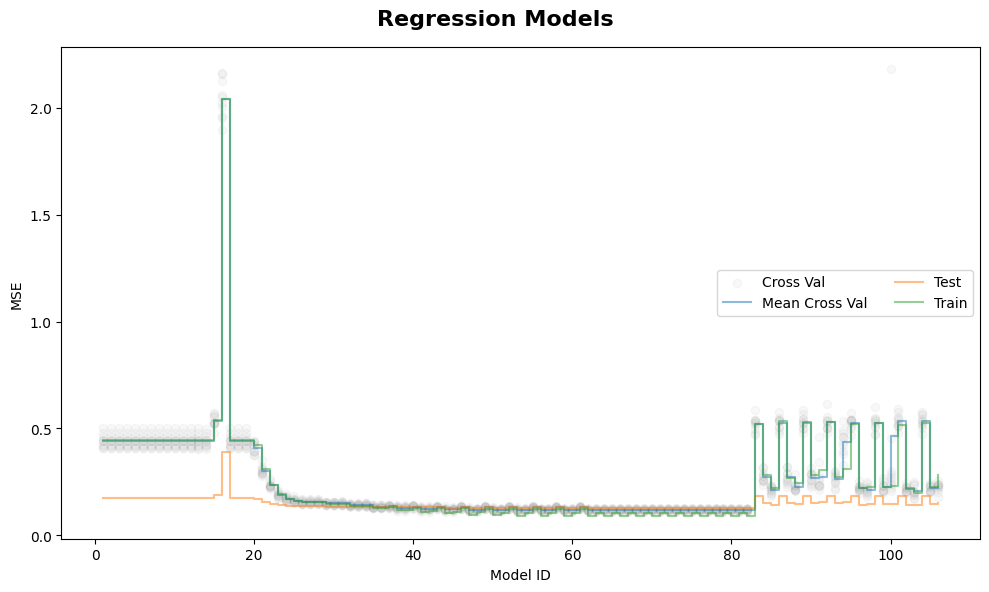

In [4]:
fig,ax0 = plt.subplots(figsize=(10,6), tight_layout=True)
fig.suptitle('Regression Models', fontweight='bold', fontsize=16)
# scatter plot of cross-val scores
xaxis = []
yaxis = []
for k in [k for k in mod_dict.keys() if mod_dict[k]['type']=='regression']:
    for xv in mod_dict[k]['metrics']['xval_scores']:
        xaxis.append(k)
        yaxis.append(xv)

ax0.scatter(xaxis,yaxis,
            alpha=0.05,
            color='gray')

xaxis = [k for k in mod_dict.keys() if mod_dict[k]['type']=='regression']
yaxis = [mod_dict[k]['metrics']['mean_xval_score'] for k in xaxis]
ax0.step(xaxis,yaxis,
         where='post',
         alpha=0.50)

yaxis = [mod_dict[k]['metrics']['test_mse'] for k in xaxis]
ax0.step(xaxis,yaxis,
         where='post',
         alpha=0.50)

yaxis = [mod_dict[k]['metrics']['train_mse'] for k in xaxis]
ax0.step(xaxis,yaxis,
         where='post',
         alpha=0.50)

ax0.set_xlabel('Model ID')
ax0.set_ylabel('MSE')
ax0.legend(['Cross Val','Mean Cross Val','Test','Train'],ncols=2)

del(fig,ax0,xaxis,yaxis,k,xv)

Classification Models

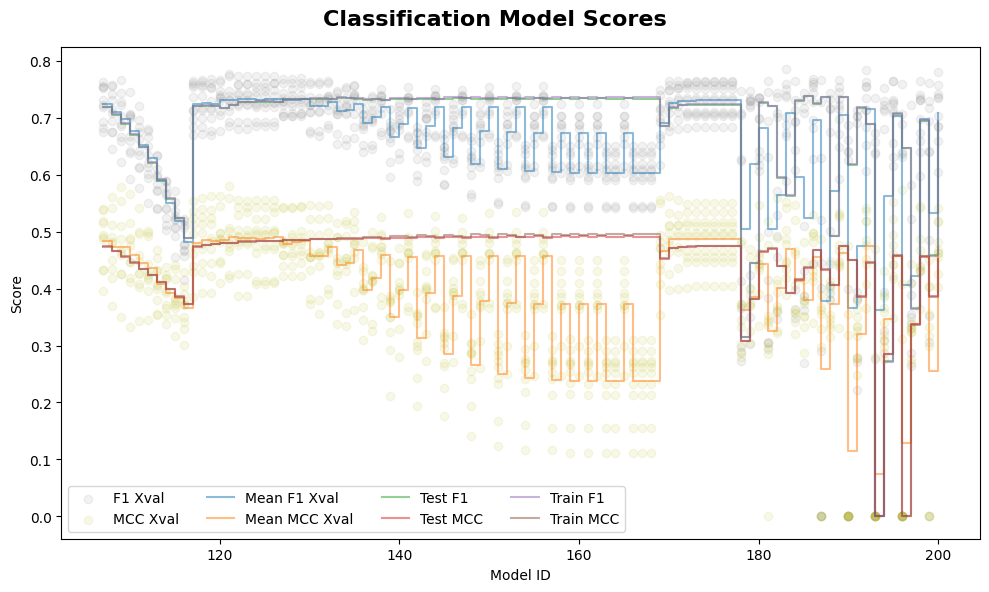

In [5]:
fig,ax0 = plt.subplots(figsize=(10,6), tight_layout=True)
fig.suptitle('Classification Model Scores', fontweight='bold', fontsize=16)
# scatter plot of cross-val scores
xaxis = []
yaxis = []
for k in [k for k in mod_dict.keys() if mod_dict[k]['type']=='classification']:
    for xv in mod_dict[k]['metrics']['f1_xval_scores']:
        xaxis.append(k)
        yaxis.append(xv)

ax0.scatter(xaxis,yaxis,
            alpha=0.10,
            color='gray')

xaxis = []
yaxis = []
for k in [k for k in mod_dict.keys() if mod_dict[k]['type']=='classification']:
    for xv in mod_dict[k]['metrics']['mcc_xval_scores']:
        xaxis.append(k)
        yaxis.append(xv)

ax0.scatter(xaxis,yaxis,
            alpha=0.10,
            color='tab:olive')


xaxis = [k for k in mod_dict.keys() if mod_dict[k]['type']=='classification']
metrics = ['mean_f1_xval_score',
           'mean_mcc_xval_score',
           'test_f1_score',
           'test_mcc_score',
           'train_f1_score',
           'train_mcc_score']

for metric in metrics:
    yaxis = [mod_dict[k]['metrics'][metric] for k in xaxis]
    ax0.step(xaxis,yaxis,
             where='post',
             alpha=0.50)

ax0.set_xlabel('Model ID')
ax0.set_ylabel('Score')
ax0.legend(['F1 Xval',
            'MCC Xval',
            'Mean F1 Xval',
            'Mean MCC Xval',
            'Test F1',
            'Test MCC',
            'Train F1',
            'Train MCC'],
           ncols=4)

del(fig,ax0,xaxis,yaxis,k,xv, metric, metrics)

## 6. Model Evaluation

We will evaluate the performance of the model candidates by answering the following questions:

- How well do the models score and how well do they generalize?
- How do the models compare to the Baseball Reference exemplars?
- How do the models perform by each event type?



### 6.1 Initial Selection

Add Combined Scores


In [6]:
# add combined scores
for k in mod_dict.keys():
    if mod_dict[k]['type'] == 'regression':
        mod_dict[k]['metrics']['comb_score1'] = np.mean([mod_dict[k]['metrics']['mean_xval_score'],
                                                         mod_dict[k]['metrics']['test_mse'],
                                                         mod_dict[k]['metrics']['train_mse']])
        mod_dict[k]['metrics']['comb_score2'] = abs(mod_dict[k]['metrics']['train_mse']-mod_dict[k]['metrics']['test_mse']) * (mod_dict[k]['metrics']['train_mse']*mod_dict[k]['metrics']['test_mse'])**0.5
    else:
        mod_dict[k]['metrics']['comb_score1'] = np.mean([mod_dict[k]['metrics']['mean_f1_xval_score'],
                                                         mod_dict[k]['metrics']['mean_mcc_xval_score'],
                                                         mod_dict[k]['metrics']['test_f1_score'],
                                                         mod_dict[k]['metrics']['test_mcc_score'],
                                                         mod_dict[k]['metrics']['train_f1_score'],
                                                         mod_dict[k]['metrics']['train_mcc_score']])
        denom = abs(mod_dict[k]['metrics']['test_f1_score']-mod_dict[k]['metrics']['train_f1_score'])
        denom = denom*abs(mod_dict[k]['metrics']['test_mcc_score']-mod_dict[k]['metrics']['train_mcc_score'])
        if denom!=0:
            numer = mod_dict[k]['metrics']['test_f1_score']*mod_dict[k]['metrics']['train_f1_score']
            numer = numer*(mod_dict[k]['metrics']['test_mcc_score']*mod_dict[k]['metrics']['train_mcc_score'])
            mod_dict[k]['metrics']['comb_score2'] = (numer**0.25)/denom

del(numer,denom,k)

Keep the models with the best combined scores for each method.

In [7]:
# regression
methods = list(set([mod_dict[k]['method'] for k in mod_dict.keys() if mod_dict[k]['type']=='regression']))
metrics = ['comb_score1','comb_score2']
keep_list_reg = []
keep_num = 1

for method in methods:
    for metric in metrics:
        temp_list = []
        k = 0
        for k in mod_dict.keys():
            if mod_dict[k]['method'] == method:
                temp_list.append(mod_dict[k]['metrics'][metric])

        temp_list = sorted(temp_list)[:keep_num]
        for k in mod_dict.keys():
            if mod_dict[k]['type']=='regression':
                if mod_dict[k]['metrics'][metric] in temp_list:
                    keep_list_reg.append(k)


keep_list_reg = list(set(keep_list_reg))


# classification
methods = list(set([mod_dict[k]['method'] for k in mod_dict.keys() if mod_dict[k]['type']=='classification']))
metrics = ['comb_score1','comb_score2']
keep_list_clf = []
keep_num = 1

for method in methods:
    for metric in metrics:
        temp_list = []
        k = 0
        for k in mod_dict.keys():
            if mod_dict[k]['method'] == method and metric in mod_dict[k]['metrics'].keys():
                temp_list.append(mod_dict[k]['metrics'][metric])

        temp_list = sorted(temp_list)[-keep_num:]
        for k in mod_dict.keys():
            if mod_dict[k]['type']=='classification' and metric in mod_dict[k]['metrics'].keys():
                if mod_dict[k]['metrics'][metric] in temp_list:
                    keep_list_clf.append(k)

keep_list_clf = list(set(keep_list_clf))

del(methods, keep_num, temp_list, k)
del(method)
del(metric, metrics)

Plot the model results by the remaining scoring metrics over the testing data, training data, and the cross-validation scores. For the regression models, we use the mean-squared error.

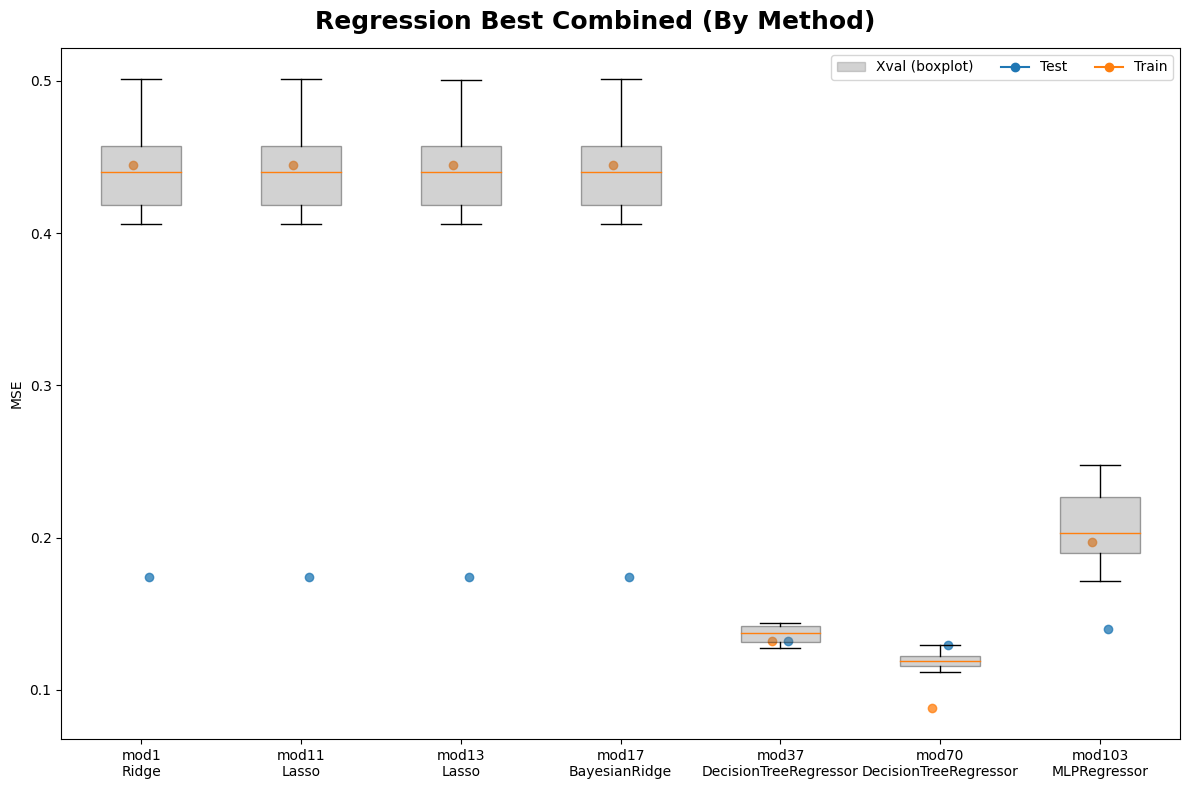

In [8]:
# regression
fig,ax0 = plt.subplots(figsize=(12,8), tight_layout=True)
fig.suptitle('Regression Best Combined (By Method)',fontweight='bold',fontsize=18)
# box plot of cross-val scores
models = []
cvs = []
for k in sorted(keep_list_reg):
    models.append('mod'+str(k)+'\n'+mod_dict[k]['method'])
    cvs.append(np.array(mod_dict[k]['metrics']['xval_scores']))

bp = ax0.boxplot(cvs,patch_artist=True)
_ = [patch.set_alpha(0.35) for patch in bp['boxes']]
_ = [patch.set_facecolor('gray') for patch in bp['boxes']]
_ = [patch.set_edgecolor('black') for patch in bp['boxes']]

ax0.set_xticklabels(models)
ax0.set_ylabel('MSE')

for metric in ['test_mse','train_mse']:
    if 'test' in metric:
        xaxis = [i+0.05 for i in range(1,len(models)+1,1)]
        ax0.scatter(xaxis,
                    [mod_dict[k]['metrics'][metric] for k in sorted(keep_list_reg)],
                    marker='o',
                    alpha=0.75)

    elif 'train' in metric:
        xaxis = [i-0.05 for i in range(1,len(models)+1,1)]
        ax0.scatter(xaxis,
                    [mod_dict[k]['metrics'][metric] for k in sorted(keep_list_reg)],
                    marker='o',
                    alpha=0.75)

    else:
        ax0.scatter(range(1,len(models)+1,1),
                    [mod_dict[k]['metrics'][metric] for k in sorted(keep_list_reg)],
                    marker='o',
                    alpha=0.75)

cust_legend = [mpatches.Patch(label='Xval (boxplot)',color='gray',alpha=0.35),
               Line2D([0],[0],label='Test',marker='o',c='tab:blue'),
               Line2D([0],[0],label='Train',marker='o',c='tab:orange'),
               ]
ax0.legend(handles=cust_legend,
           ncols=4)




For the classification models we use the F1 score and the Matthews correlation coefficient:

<ipython-input-9-974456f05e8e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(models)


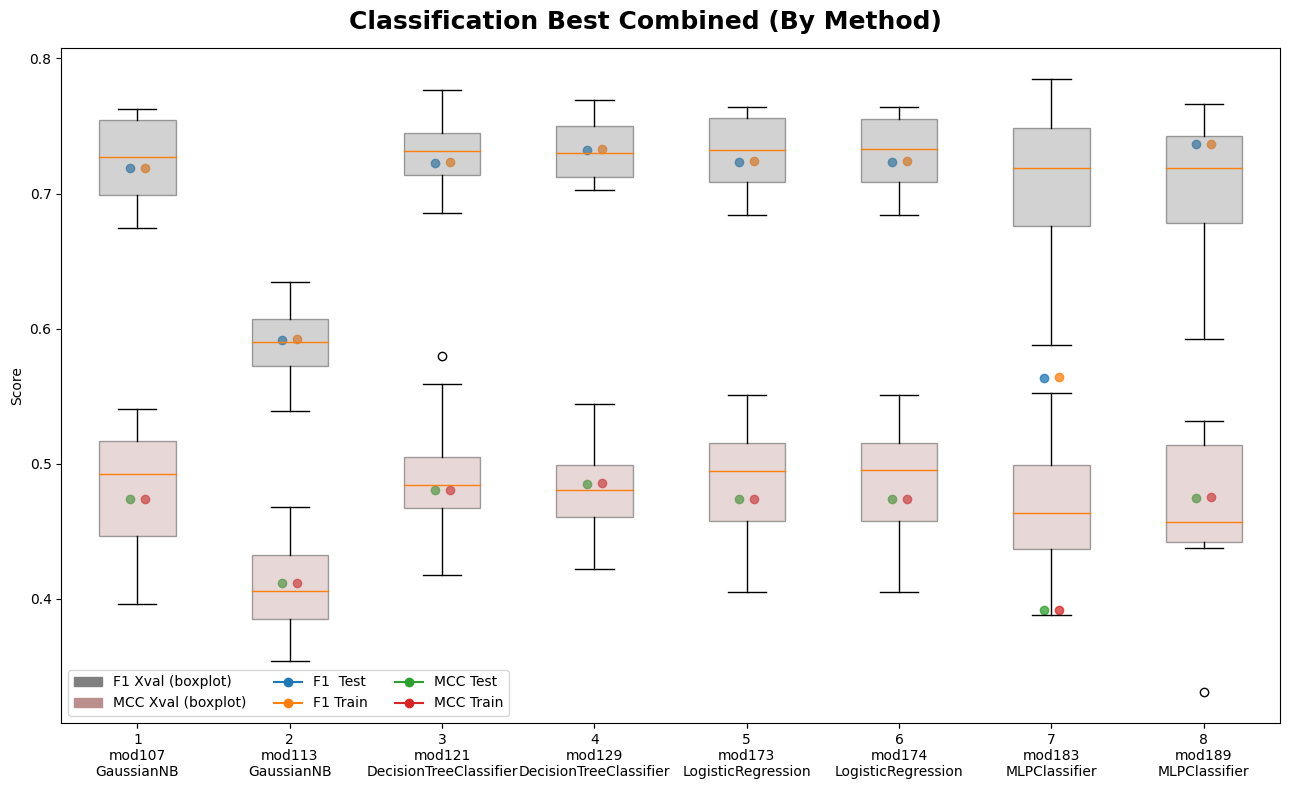

In [9]:
# classification
fig,ax0 = plt.subplots(figsize=(13,8), tight_layout=True)
fig.suptitle('Classification Best Combined (By Method)',fontweight='bold',fontsize=18)
# box plot of cross-val scores
models = []

# F1 cross-val scores
cvs = []
for k in sorted(keep_list_clf):
    models.append('\nmod'+str(k)+'\n'+mod_dict[k]['method'])
    cvs.append(np.array(mod_dict[k]['metrics']['f1_xval_scores']))

ax0.set_xticklabels(models)
ax0.set_ylabel('Score')

bp_f1 = ax0.boxplot(cvs,patch_artist=True)
_ = [patch.set_alpha(0.35) for patch in bp_f1['boxes']]
_ = [patch.set_facecolor('gray') for patch in bp_f1['boxes']]
_ = [patch.set_edgecolor('black') for patch in bp_f1['boxes']]

# MCC cross-val scores
cvs = []
for k in sorted(keep_list_clf):
    cvs.append(np.array(mod_dict[k]['metrics']['mcc_xval_scores']))

bp_mcc = ax0.boxplot(cvs,patch_artist=True)
_ = [patch.set_alpha(0.35) for patch in bp_mcc['boxes']]
_ = [patch.set_facecolor('rosybrown') for patch in bp_mcc['boxes']]
_ = [patch.set_edgecolor('black') for patch in bp_mcc['boxes']]

for metric in ['test_f1_score',
               'train_f1_score',
               'test_mcc_score',
               'train_mcc_score']:

    if 'test' in metric:
        xaxis = [i-0.05 for i in range(1,len(models)+1,1)]
        ax0.scatter(xaxis,
                    [mod_dict[k]['metrics'][metric] for k in sorted(keep_list_clf)],
                    marker='o',
                    alpha=0.75)
    elif 'train' in metric:
        xaxis = [i+0.05 for i in range(1,len(models)+1,1)]
        ax0.scatter(xaxis,
                    [mod_dict[k]['metrics'][metric] for k in sorted(keep_list_clf)],
                    marker='o',
                    alpha=0.75)
    else:
        ax0.scatter(range(1,len(models)+1,1),
                    [mod_dict[k]['metrics'][metric] for k in sorted(keep_list_clf)],
                    marker='o',
                    alpha=0.75)

cust_legend = [mpatches.Patch(label='F1 Xval (boxplot)',color='gray'),
               mpatches.Patch(label='MCC Xval (boxplot)',color='rosybrown'),
               Line2D([0],[0],label='F1  Test',marker='o',c='tab:blue'),
               Line2D([0],[0],label='F1 Train',marker='o',c='tab:orange'),
               Line2D([0],[0],label='MCC Test',marker='o',c='tab:green'),
               Line2D([0],[0],label='MCC Train',marker='o',c='tab:red')
               ]
ax0.legend(handles=cust_legend,
           ncols=3)

del(fig, ax0, k, models, cvs, metric, cust_legend, xaxis, bp_f1, bp_mcc, bp)

### 6.2 Compare to Baseball Reference Exemplars

In [17]:
# get processing dictionaries
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/preprocess_dict.pkl

pre_pro_dicts = pickle.load(open('/content/temp_folder/preprocess_dict.pkl', 'rb'))

park_factors = pre_pro_dicts['park_fact']
season_factors = pre_pro_dicts['season_fact']

scale_dict = {'bbr_inning': (1, 9),
              'outs': (0, 2),
              'bbr_outs_played': (0, 53),
              'bbr_score_diff': (-11, 11)}

del(pre_pro_dicts)

--2024-01-16 15:30:18--  https://github.com/cmtoner/retrosheets_we_wpa/raw/main/preprocess_dict.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cmtoner/retrosheets_we_wpa/main/preprocess_dict.pkl [following]
--2024-01-16 15:30:18--  https://raw.githubusercontent.com/cmtoner/retrosheets_we_wpa/main/preprocess_dict.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085 (5.0K) [application/octet-stream]
Saving to: ‘/content/temp_folder/preprocess_dict.pkl.6’

preprocess_dict.pkl 100%[===================>]   4.97K  --.-KB/s    in 0s      

2024-01-16 15:30:18 (54.1 MB/s) - ‘/content/temp_folde

Get a slice of the Retrosheet events data. The slice contains eight randomly selected games between the 1985 and 2022 seasons, as well as events from the full 2010 season.

In [18]:
# get slice of events file
df_slice = pd.read_csv('https://github.com/cmtoner/retrosheets_we_wpa/raw/main/event_slice.zip',
                       header=0,
                       index_col=0)

# clean/scale df_slice according to scaling dict
df_slice['bbr_inning'] = df_slice['inning']
df_slice['bbr_inning'].loc[df_slice['bbr_inning']>9 ] = 9
df_slice['bbr_outs_played'] = 6*(df_slice['bbr_inning']-1) + 3*df_slice['batting_team'] + df_slice['outs']
df_slice['r_1b'] = 0
df_slice['r_1b'].loc[df_slice['run_1b'].notna()] = 1
df_slice['r_2b'] = 0
df_slice['r_2b'].loc[df_slice['run_2b'].notna()] = 1
df_slice['r_3b'] = 0
df_slice['r_3b'].loc[df_slice['run_3b'].notna()] = 1
df_slice['score_diff'] = df_slice['home_score'] - df_slice['vis_score']
df_slice['bbr_score_diff'] = df_slice['score_diff']
df_slice['bbr_score_diff'].loc[df_slice['score_diff']>=11] = 11
df_slice['bbr_score_diff'].loc[df_slice['score_diff']<=-11] = -11
df_slice = df_slice.replace({'t':1,
                             'f':0})
m0 = (df_slice['end_game']==1)&(df_slice['home_score']>=df_slice['vis_score'])
home_win_ids = list(set(df_slice['game_id'].loc[m0]))
m1 = df_slice['game_id'].isin(home_win_ids)
df_slice['home_win'] = 0
df_slice['home_win'].loc[m1] = 1

# add park/season factors
df_slice = df_slice.merge(pd.DataFrame(park_factors)["pf"],
                          how='left',
                          left_on=['park'],
                          right_index=True)

df_slice = df_slice.merge(pd.DataFrame(season_factors)["sf"],
                          how='left',
                          left_on=['season'],
                          right_index=True)

# scale
for col in ['bbr_outs_played','bbr_score_diff']:
    x_min,x_max = scale_dict[col]
    df_slice[col] = (df_slice[col]-x_min)/(x_max-x_min)

# add bbr_score_diff adjusted by park/season factors
df_slice['bbr_score_diff_adj'] = df_slice['bbr_score_diff']/(df_slice['pf']*df_slice['sf'])
df_slice['bbr_score_diff_adj'] = df_slice['bbr_score_diff_adj']



<ipython-input-18-2ff76c43c62d>:2: DtypeWarning: Columns (59,68,69,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_slice = pd.read_csv('https://github.com/cmtoner/retrosheets_we_wpa/raw/main/event_slice.zip',


In [19]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

df_slice.head(10)

,vis_team,season,park,game_id,event_id,batting_team,inning,outs,balls,strikes,...,bbr_outs_played,r_1b,r_2b,r_3b,score_diff,bbr_score_diff,home_win,pf,sf,bbr_score_diff_adj
home_team,,,,,,,,,,,,,,,,,,,,,
ANA,MIN,2010,ANA01,ANA201004050,1,0,1,0,2,2,...,0.000000,0,0,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,2,0,1,1,0,1,...,0.018868,0,0,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,3,0,1,2,1,1,...,0.037736,0,0,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,4,1,1,0,3,2,...,0.056604,0,0,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,5,1,1,0,0,1,...,0.056604,1,0,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,6,1,1,1,0,0,...,0.075472,1,0,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,7,1,1,1,3,0,...,0.075472,0,1,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,8,1,1,1,0,2,...,0.075472,1,1,0,0,0.500000,1,0.953416,0.980896,0.534644
ANA,MIN,2010,ANA01,ANA201004050,9,1,1,2,1,1,...,0.094340,1,1,0,0,0.500000,1,0.953416,0.980896,0.534644


Get Baseball Reference exemplars. The first exemplar contains the win exepectancy from the eight randomly selected games in the events slice. The second exemplar is the aggregated WPA for the top 500 players from the 2010 season.

In [20]:
# get exemplars from file
bbref_ex01 = pd.read_csv("https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbref_we_examplar01.csv",
                         header=0,
                         index_col=False)

bbref_ex02 = pd.read_csv("https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbref_wpa_2010_exemplar01.csv",
                         header=0,
                         index_col=False)

# clean house
del(col)
del(x_min,x_max)
del(m0, m1, home_win_ids)

Make predictions on the fitted models

In [21]:
# make predictions

cols = ["r_1b",
        "r_2b",
        "r_3b",
        'bbr_outs_played',
        "bbr_score_diff_adj"]

# regression models
for k in keep_list_reg:
    df_slice['yhat_m'+str(k)] = mod_dict[k]['clf'].predict(df_slice[cols])
#  classification models
for k in keep_list_clf:
    df_slice['yhat_m'+str(k)] = [t[1] for t in mod_dict[k]['clf'].predict_proba(df_slice[cols])]

del(cols, k)

#### 6.2.1 Individual Game Results
Compare model results to the Baseball Reference WE for a selection of games. Plot the WE by event for each model and visually compare the results to the Baseball Reference exemplars.

##### 6.2.1.1 All Models

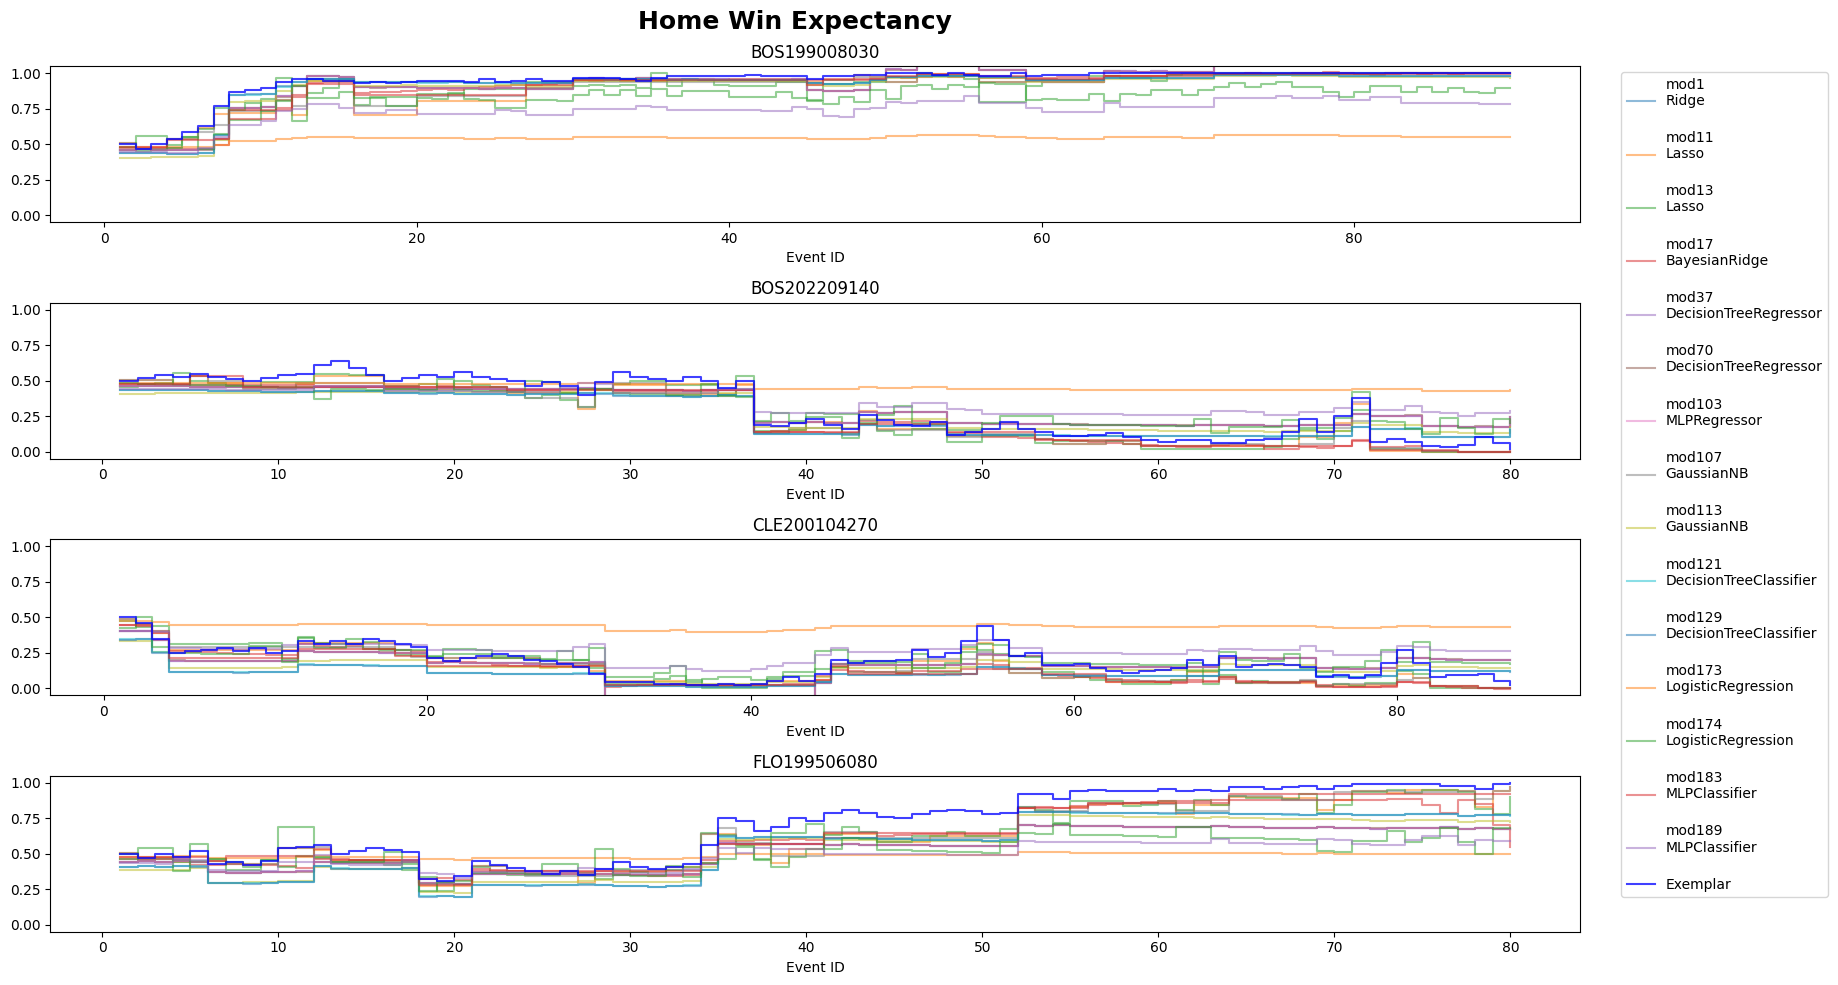

In [22]:
#%% compare to games
cols = [c for c in df_slice.columns if 'yhat' in c] + ['game_id', 'event_id']

df_temp = bbref_ex01.merge(df_slice[cols],
                           how='inner',
                           left_on=['game_id','event_id'],
                           right_on=['game_id','event_id'])


game_ids = ['BOS199008030','BOS202209140','CLE200104270','FLO199506080']

fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,1,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_xlabel('Event ID')
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [c for c in df_slice.columns if 'yhat' in c]:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
        ax[i].set_ylim([-0.05,1.05])
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
             where='post',
             alpha=0.75,
             c='blue')

leg_list = [f'mod{c}\n{mod_dict[c]["method"]}\n' for c in sorted(keep_list_reg+keep_list_clf)]
leg_list += ['Exemplar']
fig.legend(leg_list, bbox_to_anchor=(1.15,0.925))


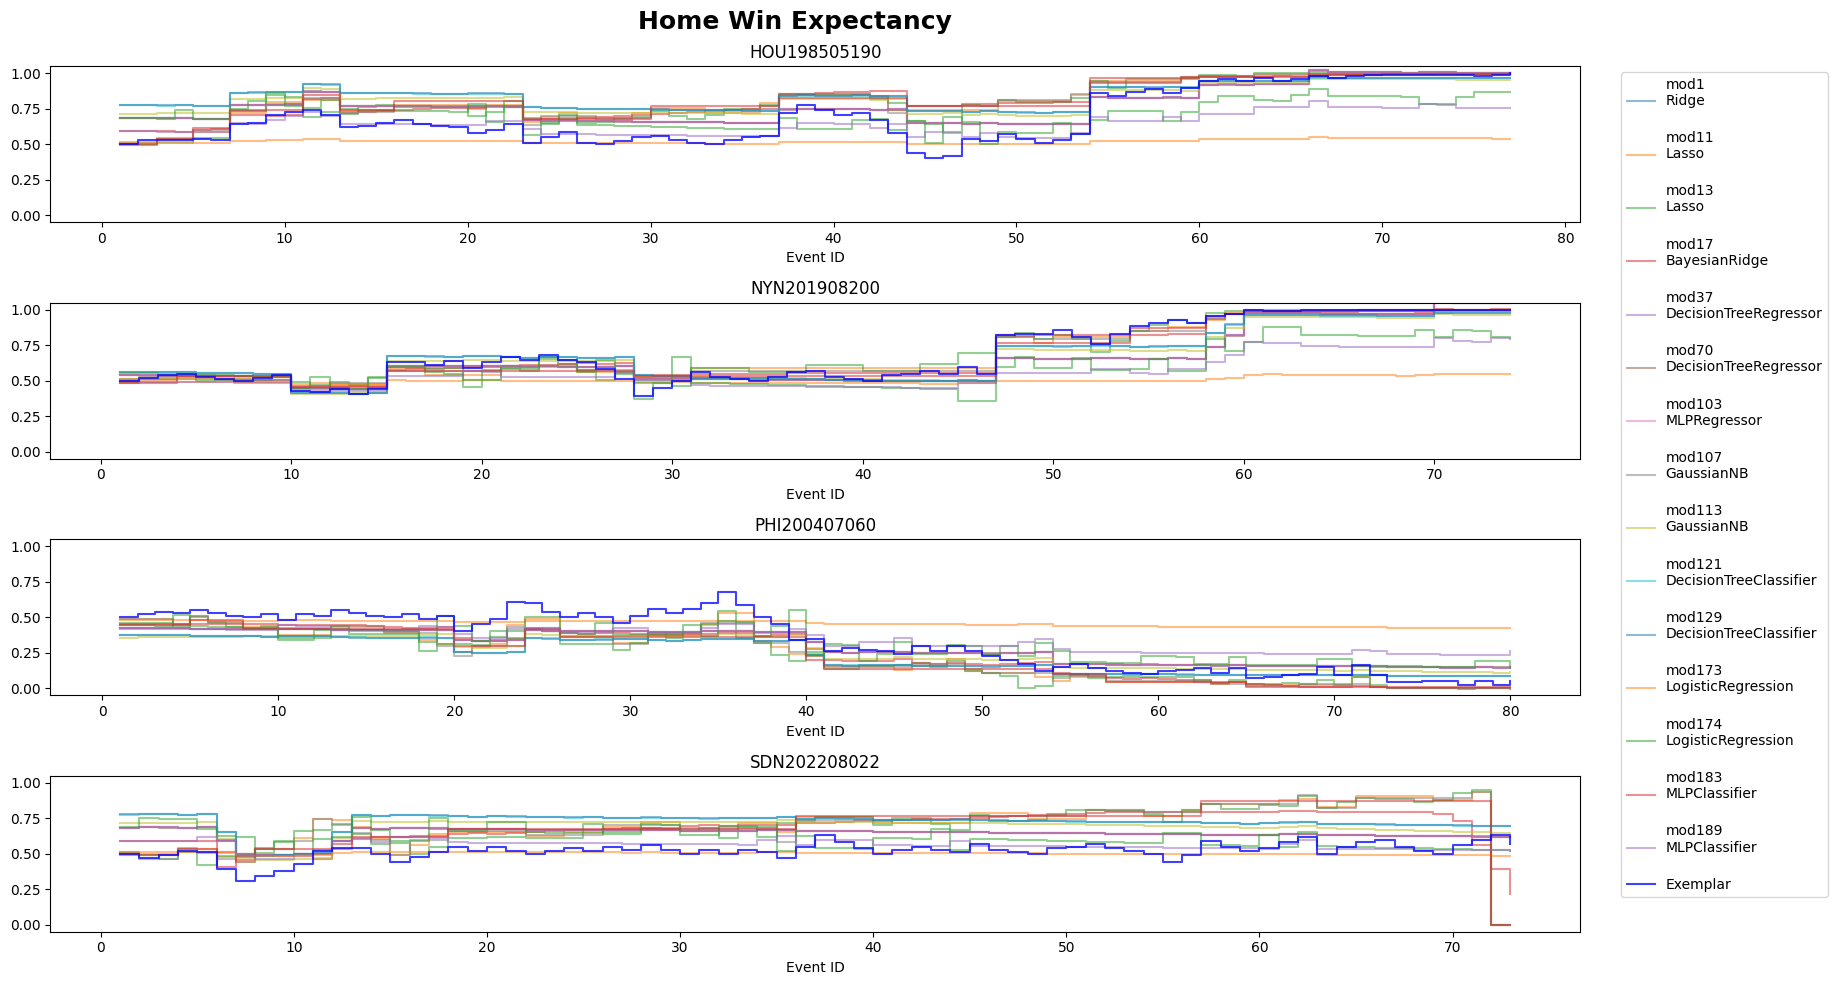

In [23]:
game_ids = ['HOU198505190','NYN201908200','PHI200407060','SDN202208022']

fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,1,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_xlabel('Event ID')
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [c for c in df_slice.columns if 'yhat' in c]:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
        ax[i].set_ylim([-0.05,1.05])
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
             where='post',
             alpha=0.75,
             c='blue')

leg_list = [f'mod{c}\n{mod_dict[c]["method"]}\n' for c in sorted(keep_list_reg+keep_list_clf)]
leg_list += ['Exemplar']
fig.legend(leg_list, bbox_to_anchor=(1.15,0.925))



With a few exceptions, the fitted models positively correlate to the exemplars. To narrow the model candidates further, we plot the win expectancy of each model individually and calculate the mean-squared error against the exemplars.


In [24]:
# SSE by model
_ = [print(f'SSE {c}: {" "*(20-len(c))} {sum((df_temp["home_win_prob"]-df_temp[c])**2)}') for c in df_temp.columns if 'yhat' in c]

del(ax, col, cols, game_id, game_ids, i, leg_list, x, y)
del(fig)

SSE yhat_m1:               8.992029842221797
SSE yhat_m37:              9.014100281446899
SSE yhat_m70:              8.877095475933732
SSE yhat_m103:             8.174090051381427
SSE yhat_m11:              8.992061180601517
SSE yhat_m13:              8.995662625664023
SSE yhat_m17:              8.99201492771233
SSE yhat_m129:             9.05382273469225
SSE yhat_m107:             9.871920734782536
SSE yhat_m173:             11.426770415265848
SSE yhat_m174:             11.503255552632147
SSE yhat_m113:             53.26131657412387
SSE yhat_m183:             12.795425093337261
SSE yhat_m121:             9.255621943958616
SSE yhat_m189:             18.395508179869175


##### 6.2.1.2 Individual models

Model 1

Ridge regression with $\alpha=0.0001$.

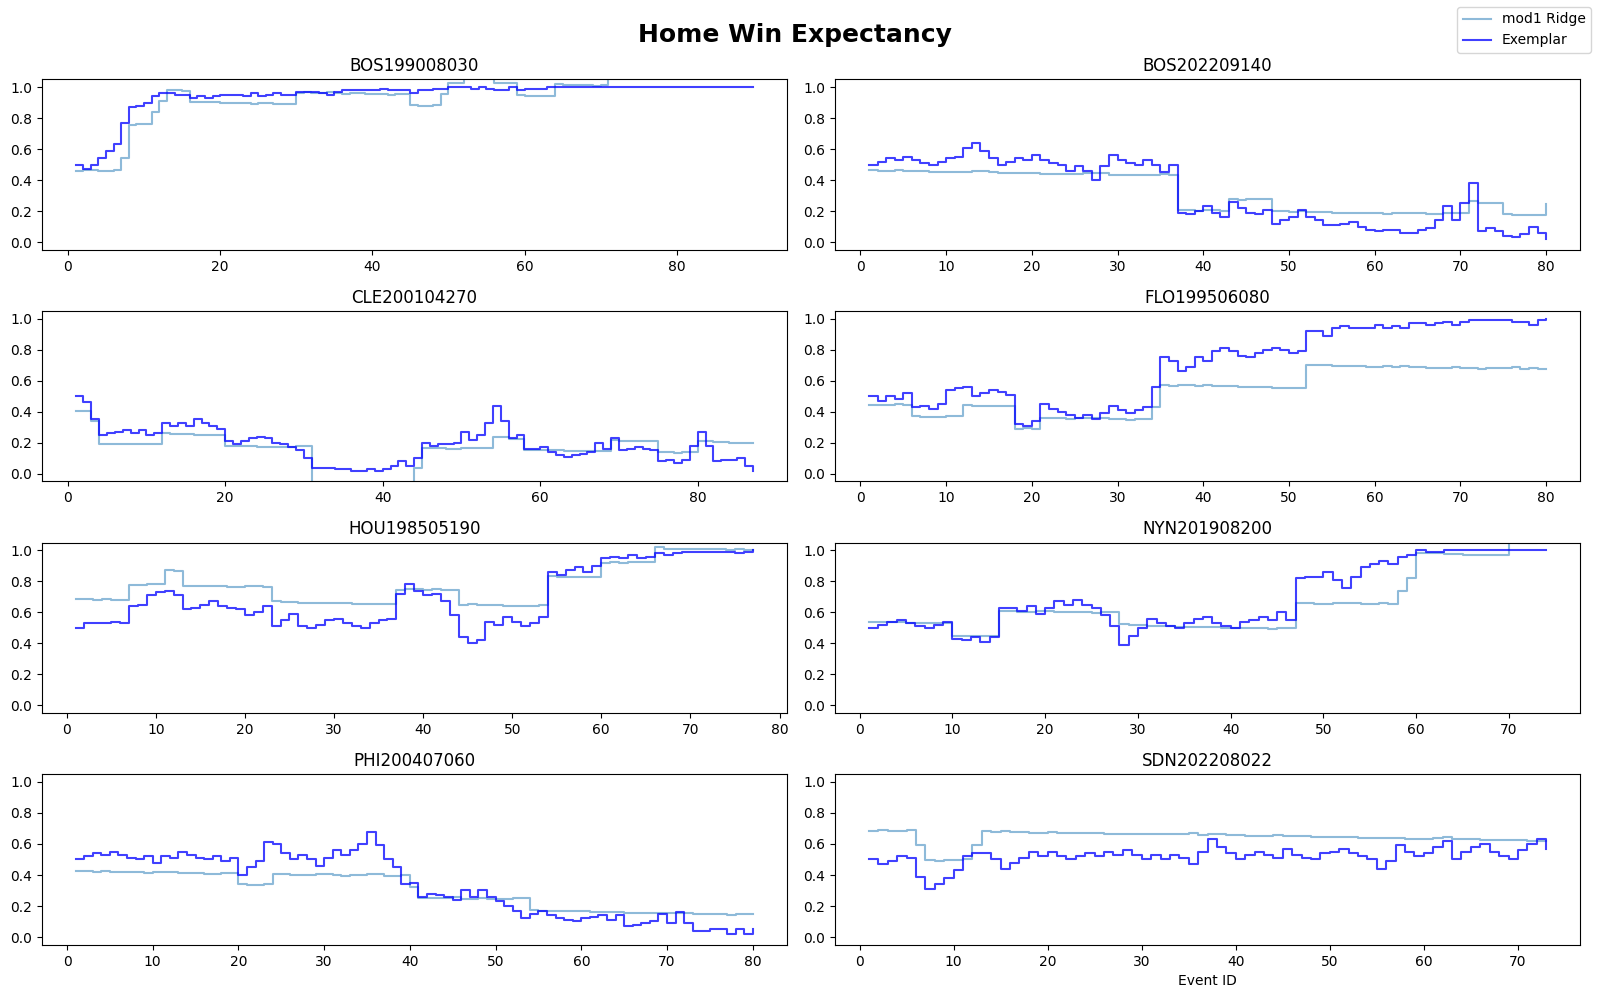

In [25]:
game_ids = ['BOS199008030','BOS202209140','CLE200104270','FLO199506080']
game_ids = game_ids + ['HOU198505190','NYN201908200','PHI200407060','SDN202208022']

fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 1

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 70

Decision tree regressor with minimum samples per terminal leaves=10 and maximium depth=24.

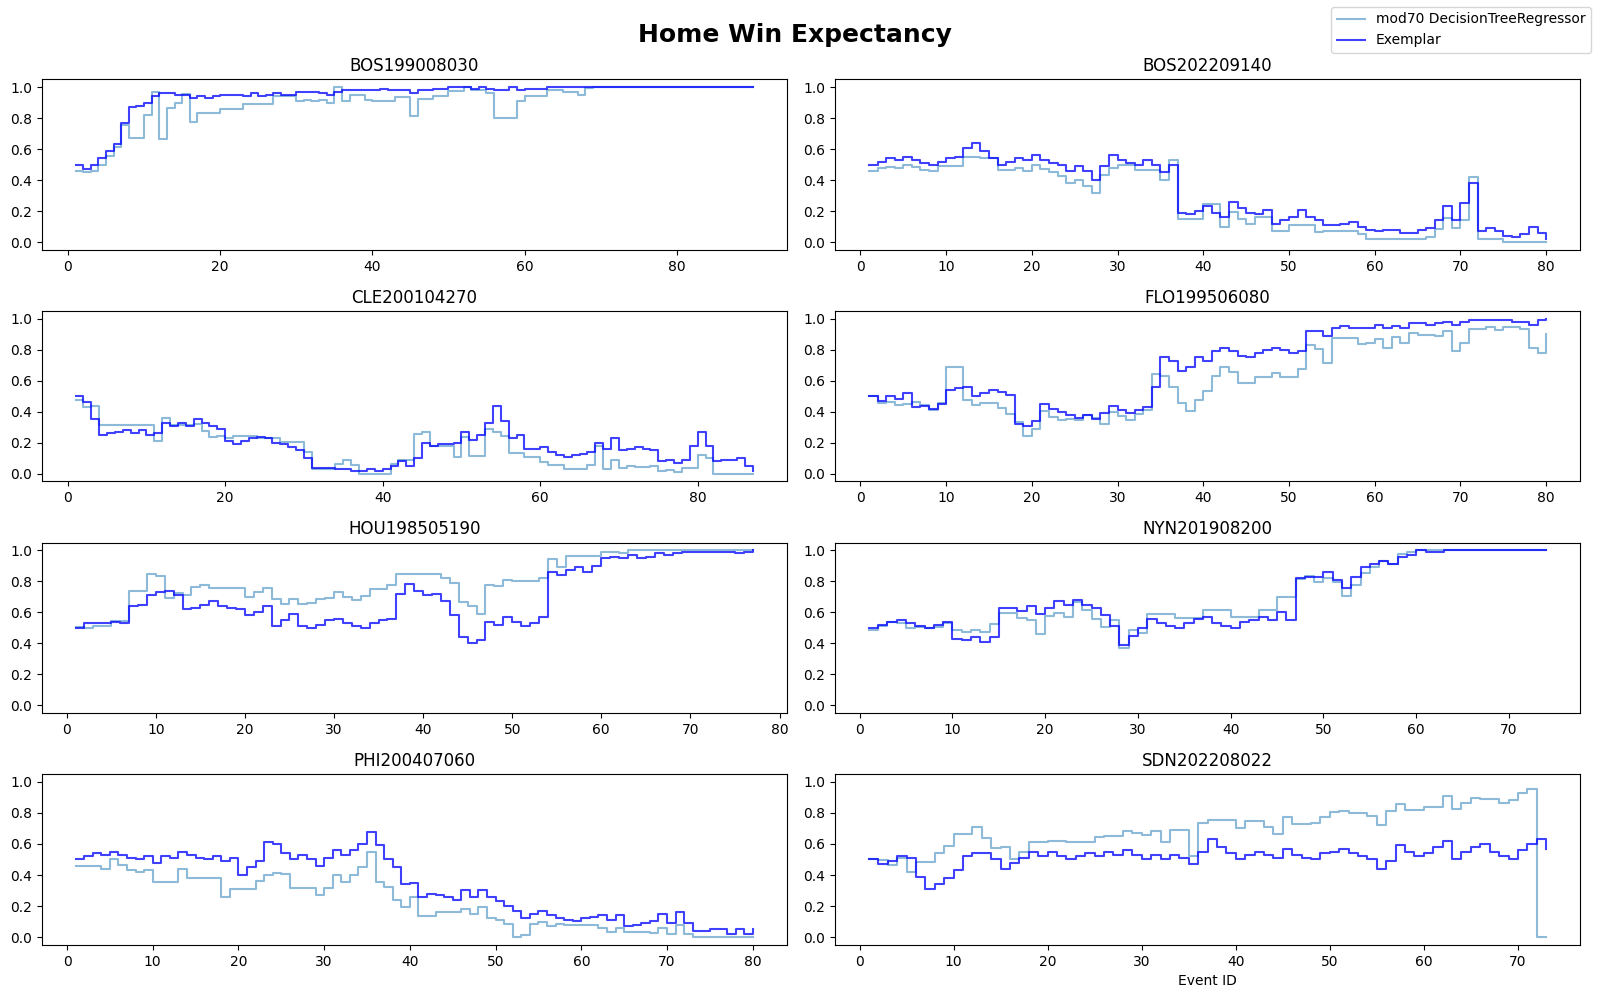

In [26]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 70

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 37

Decision tree regressor with minimum samples per terminal leaves=100 and maximium depth=11.

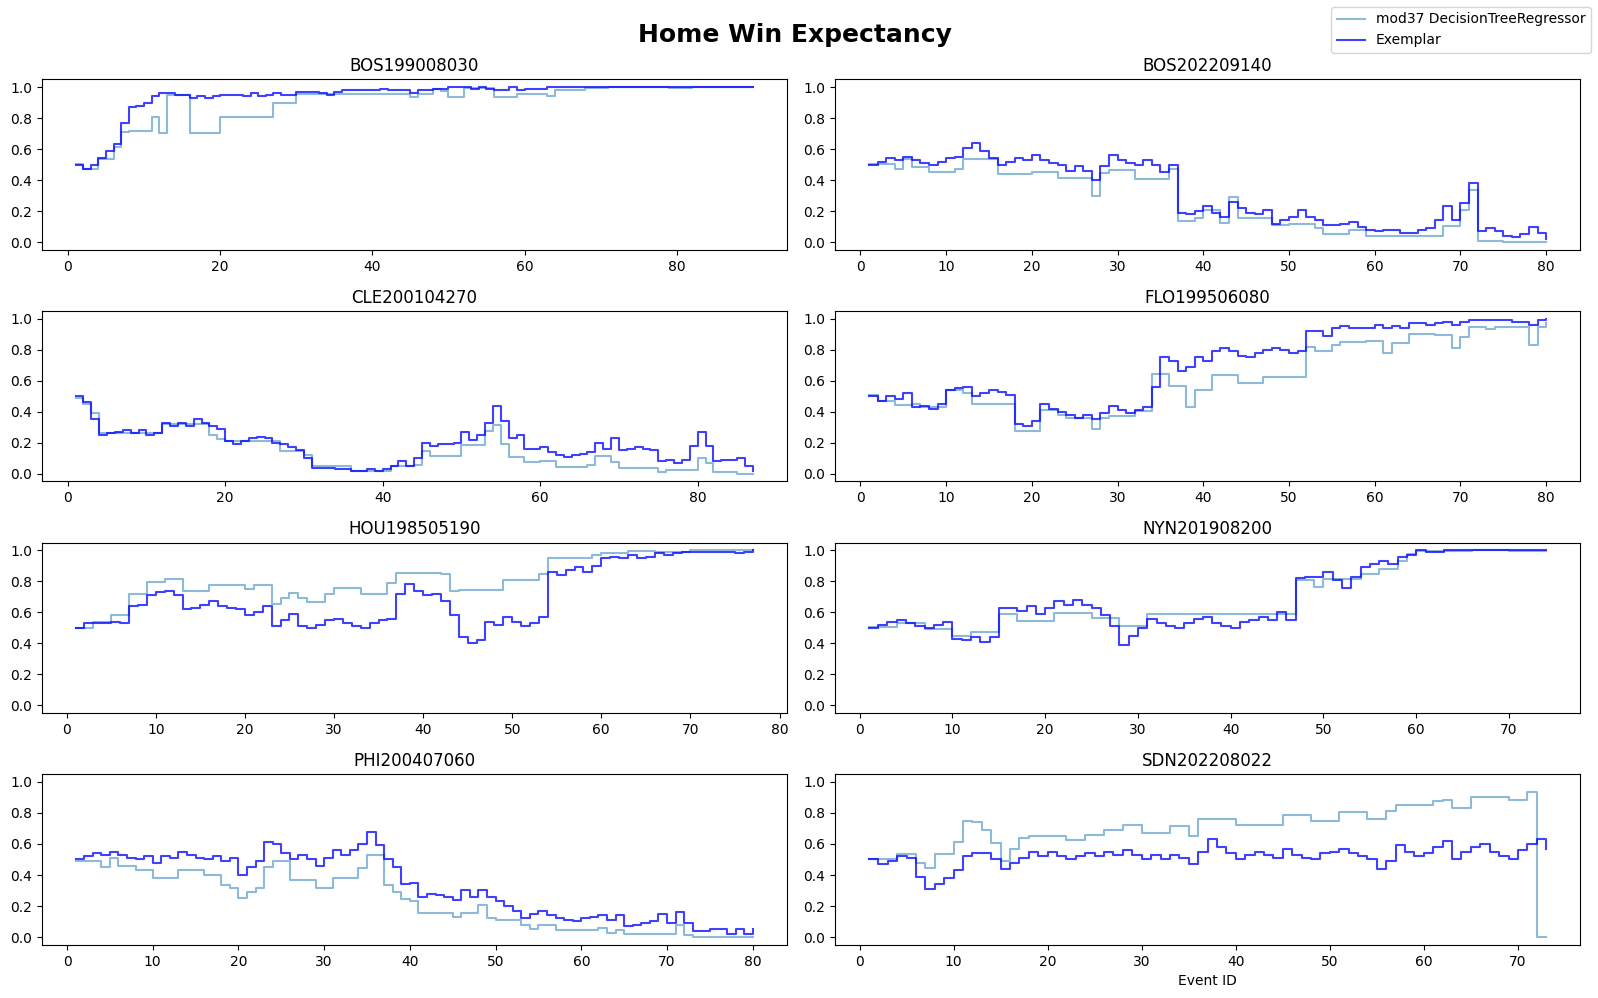

In [27]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 37

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 103

ANN with three hidden layers and 8 nodes per hidden layer.

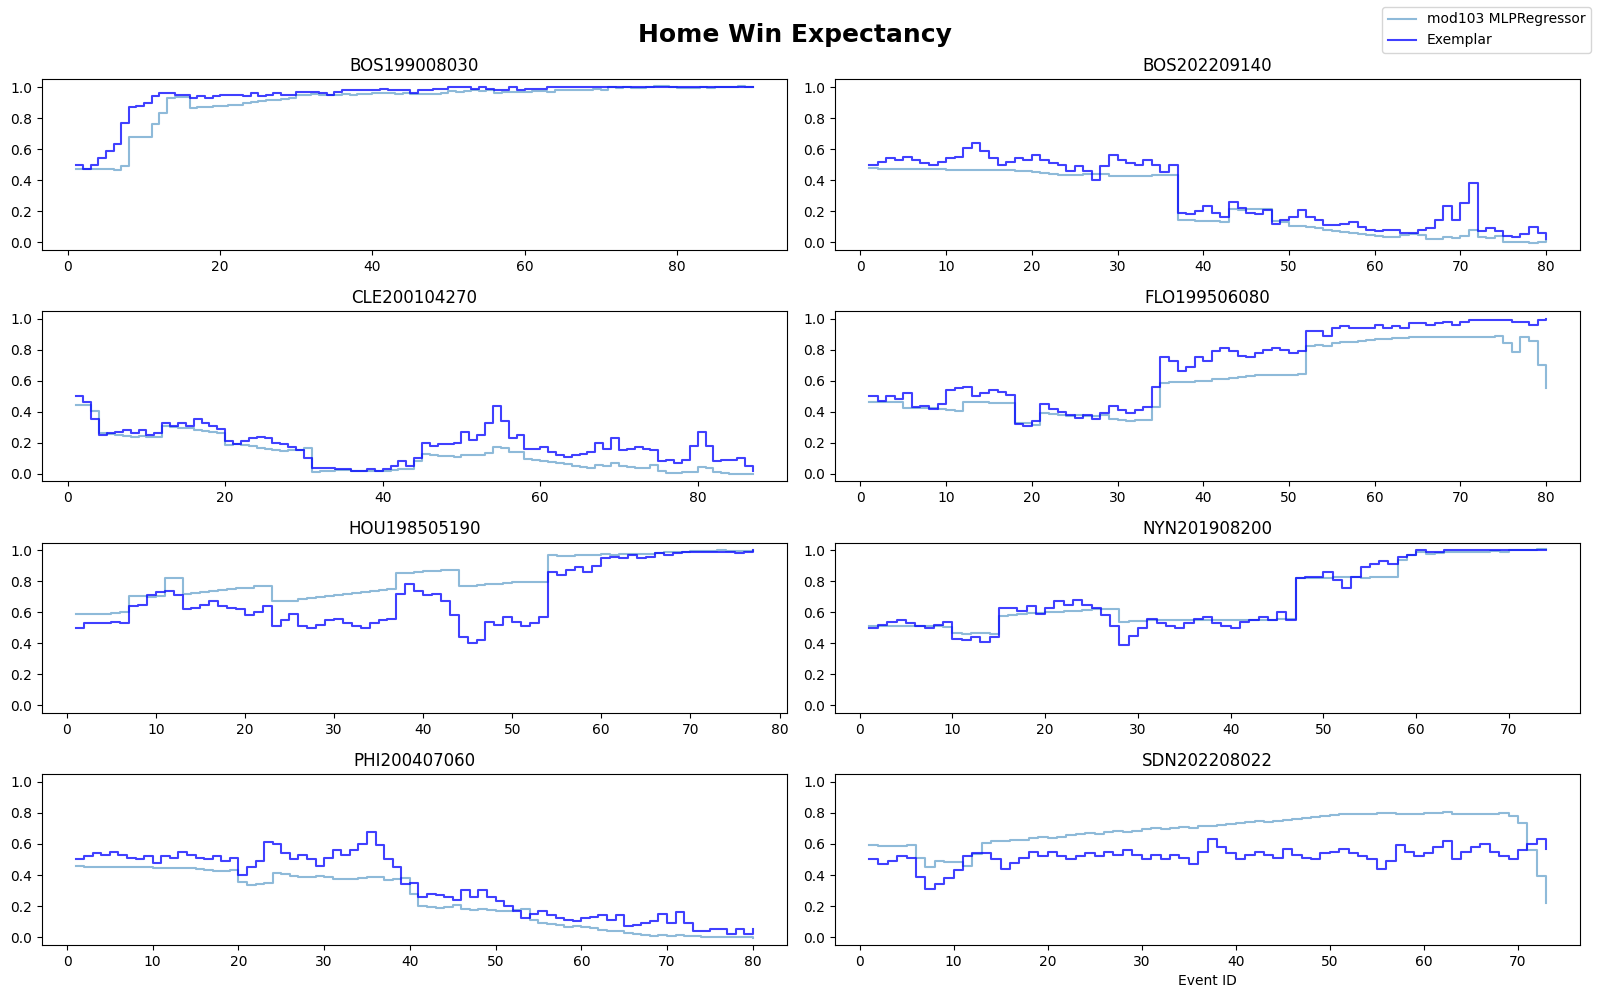

In [28]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 103

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

 Model 11

Lasso regression with $\alpha = 10^{-6}$.

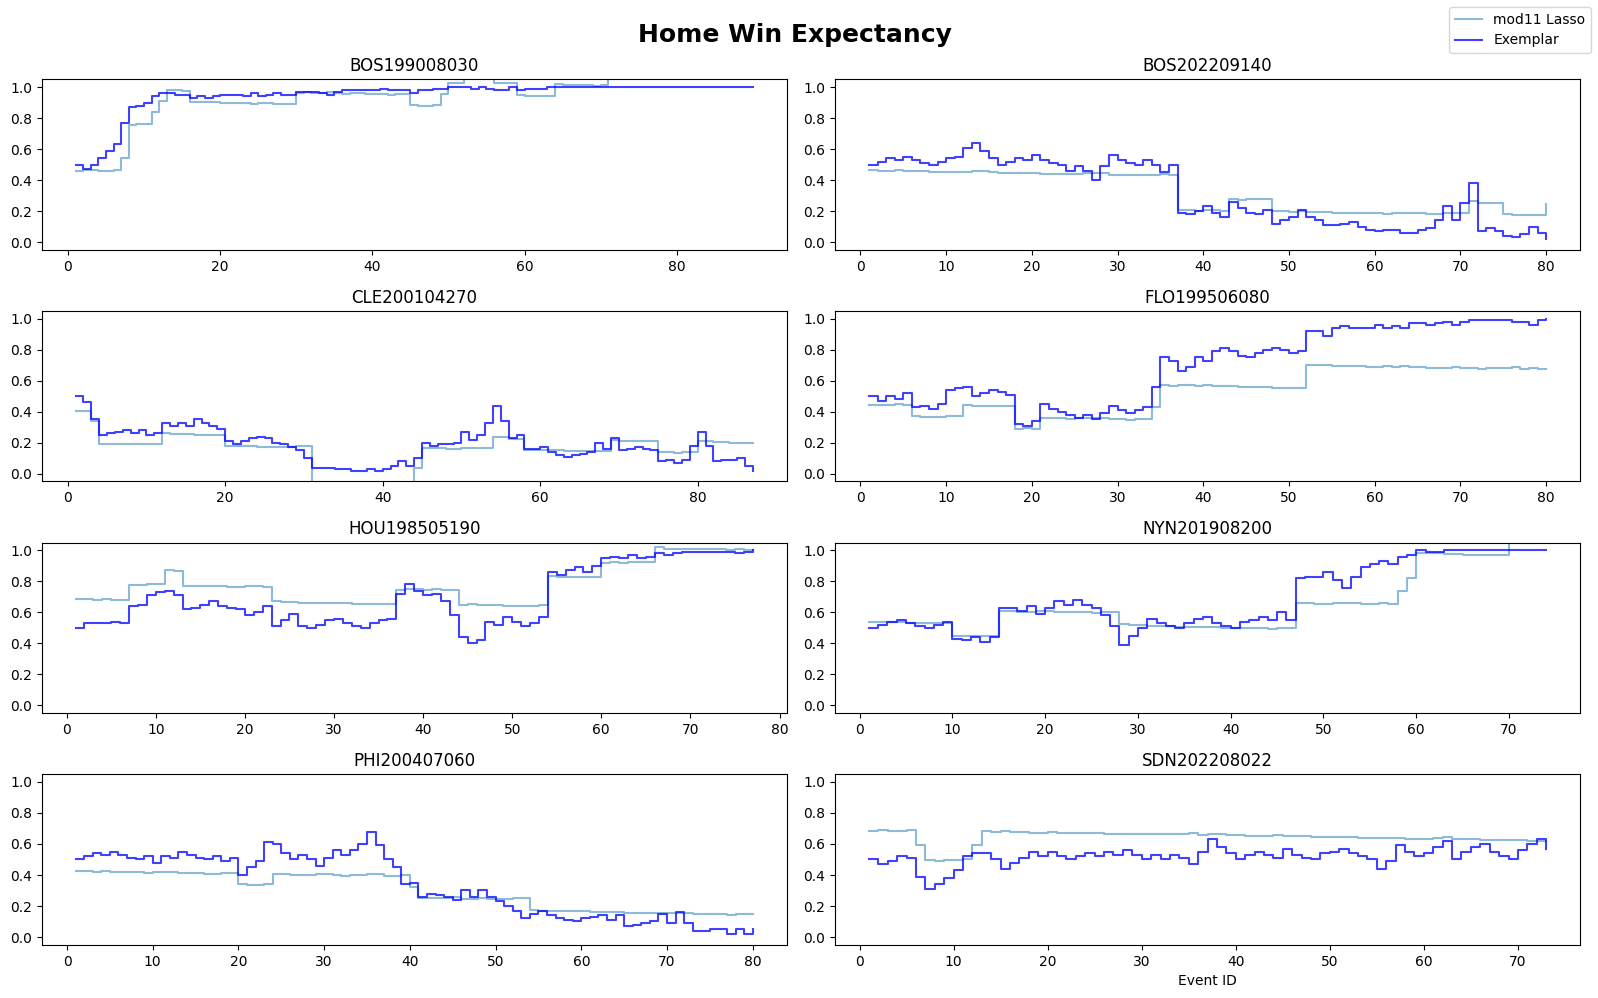

In [29]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 11

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 13

Lasso regression with $\alpha = 0.0001$.

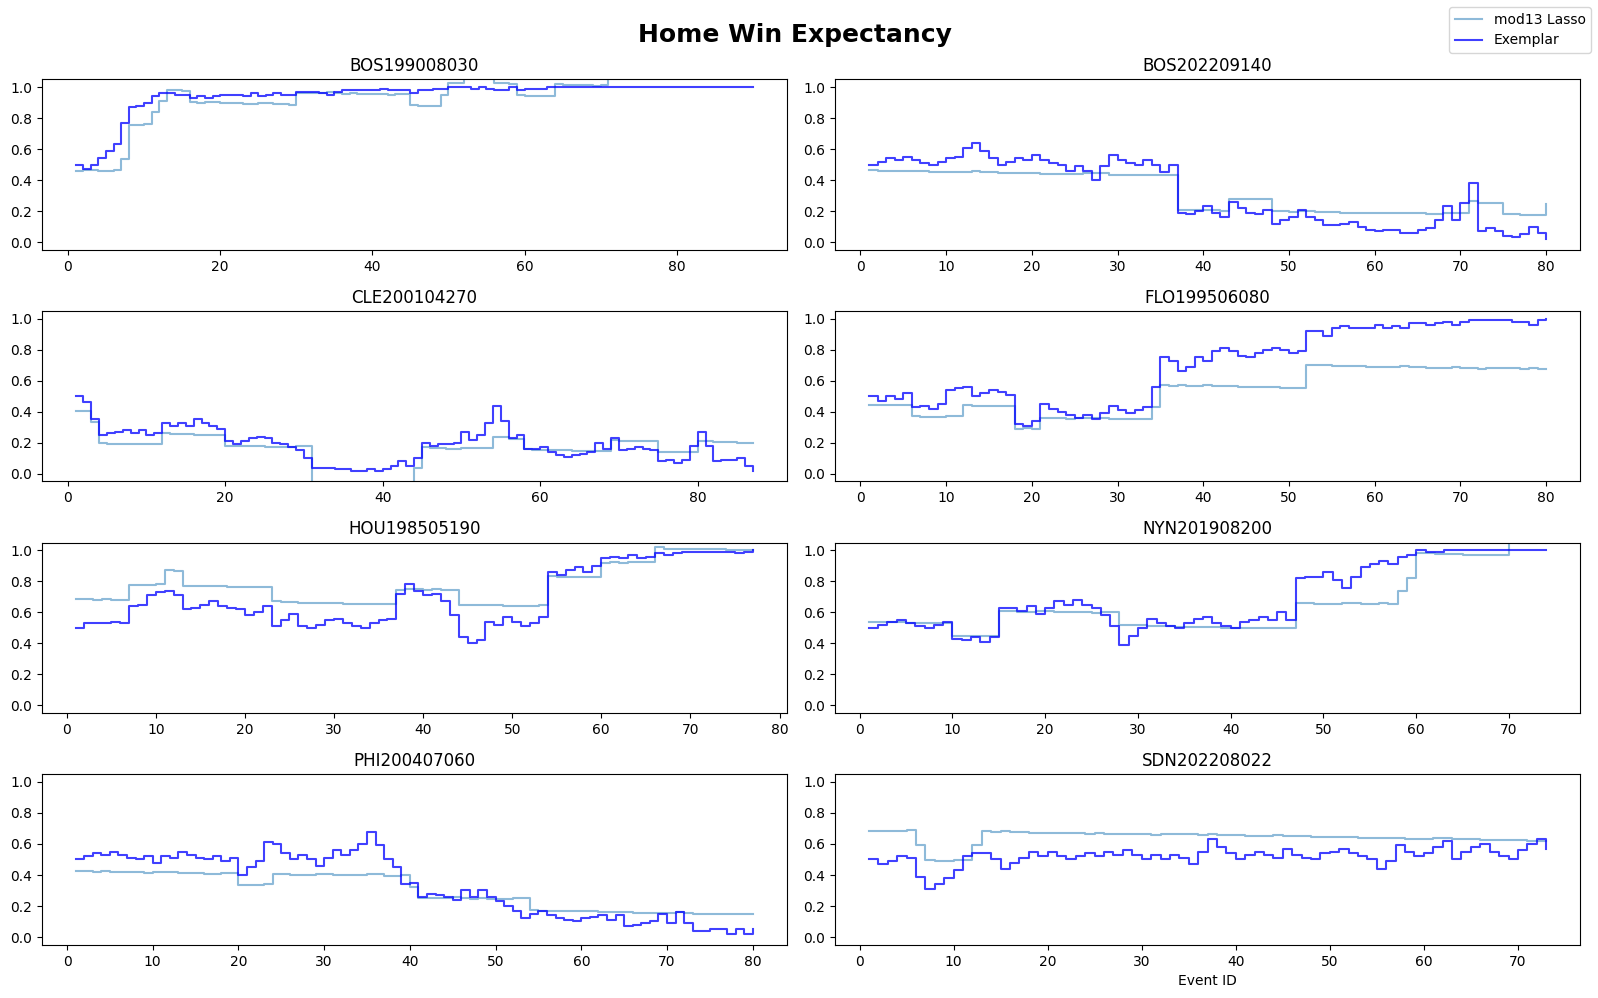

In [30]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 13

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 17

Bayesian ridge regression with $\alpha_{init} = 10^{-6}$.

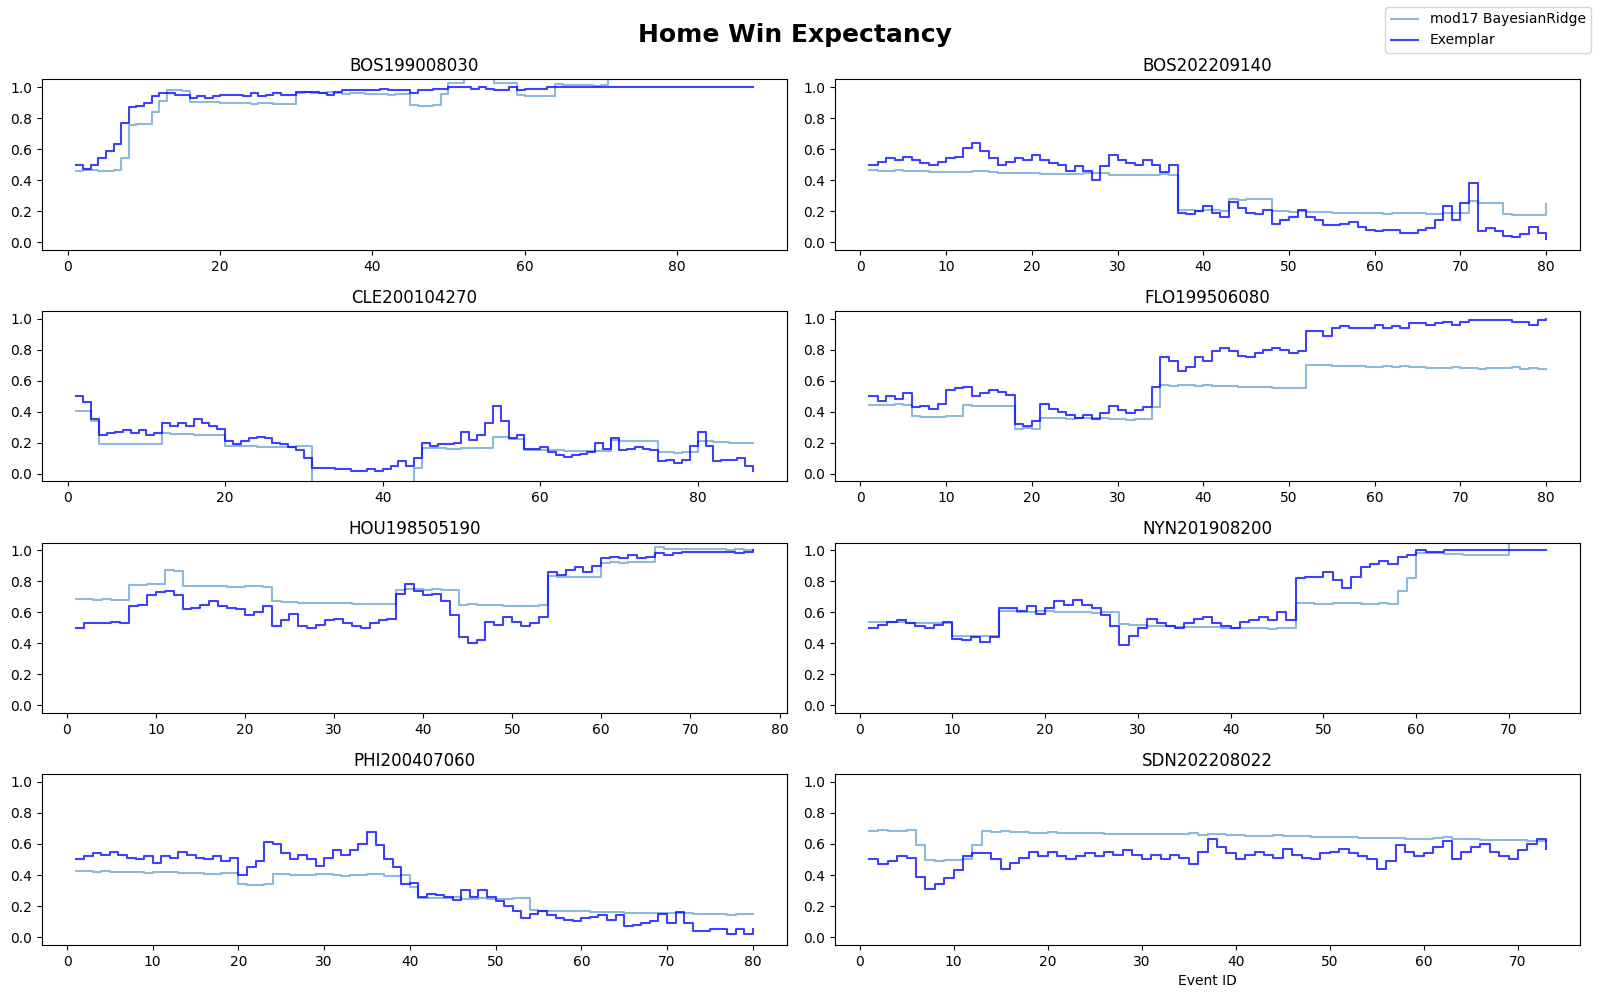

In [31]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 17

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 129

Decision tree classifier with minimum samples per terminal leaves=100 and maximum depth=10.

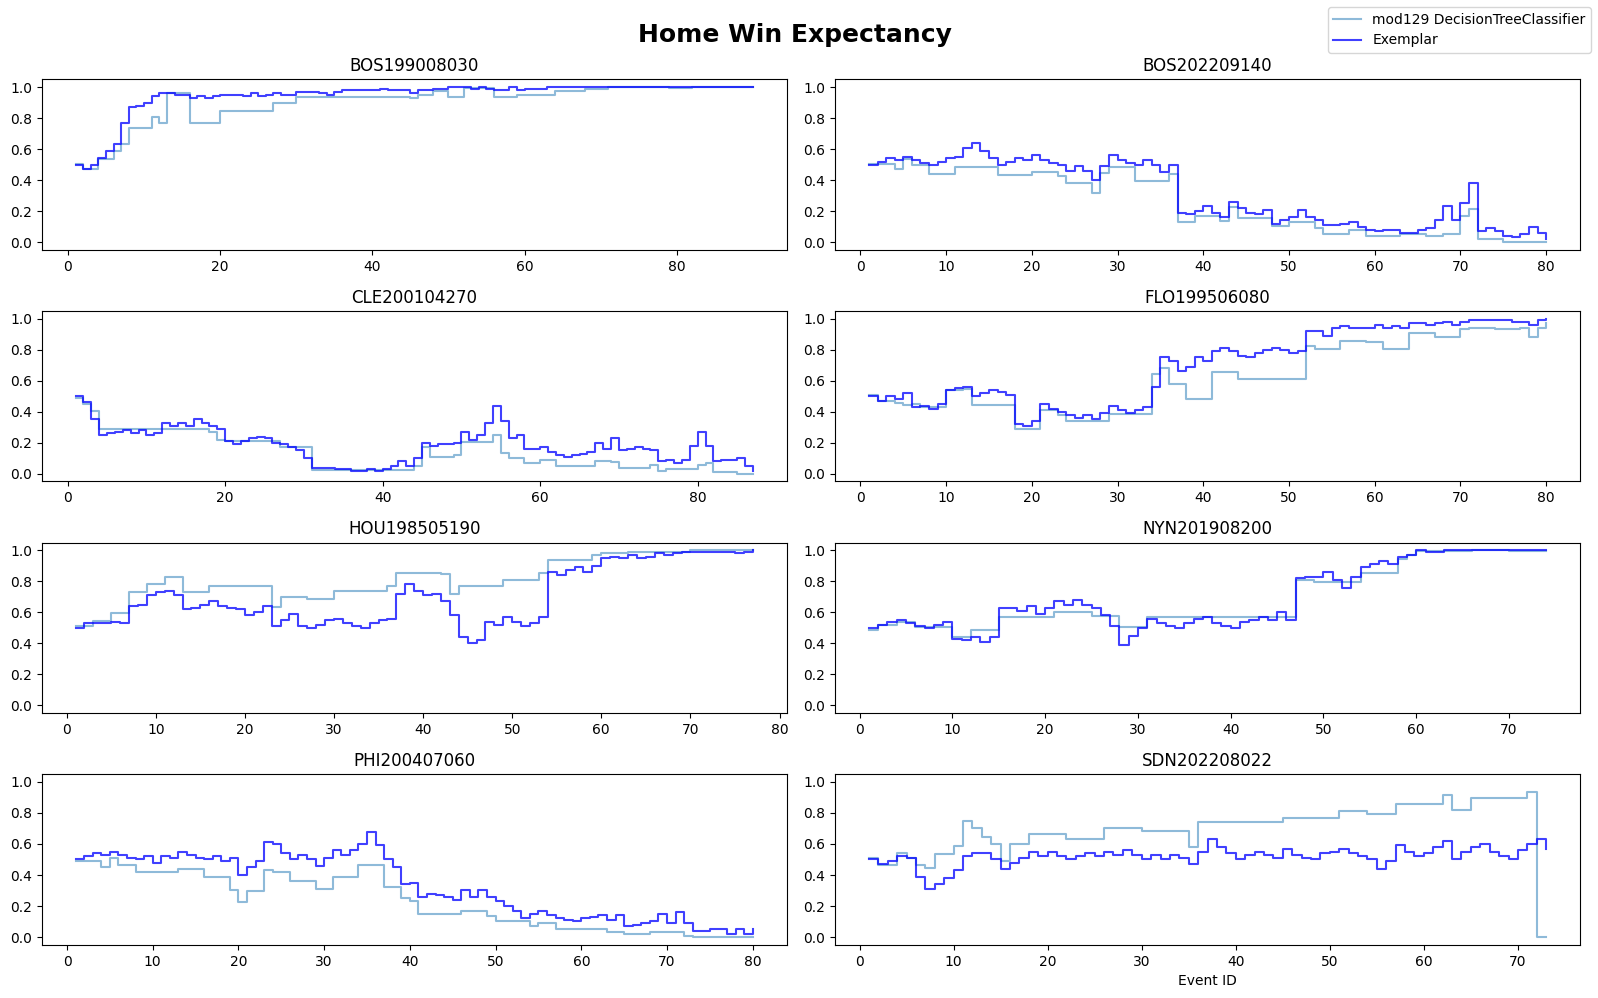

In [32]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 129

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 107

Naive Bayes classifier with $var_{smoothing}=0$.

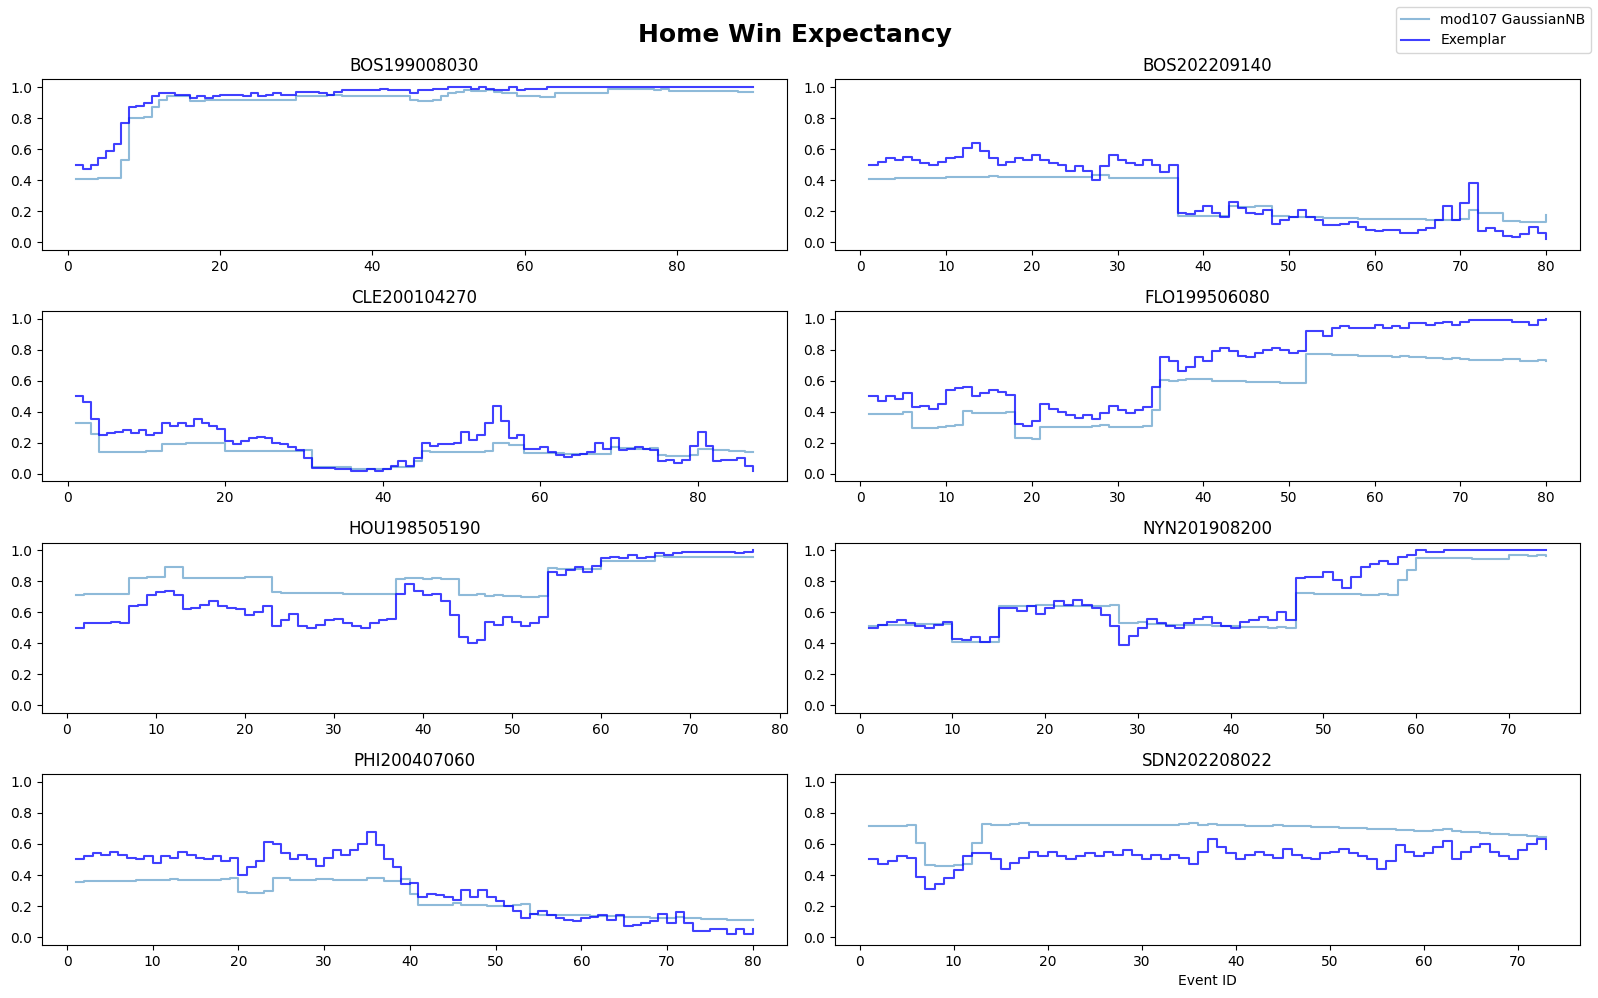

In [33]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 107

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 173

Logistic regression classifier with L2 regularization; $C=\frac{1}{\alpha}=0.0129$.

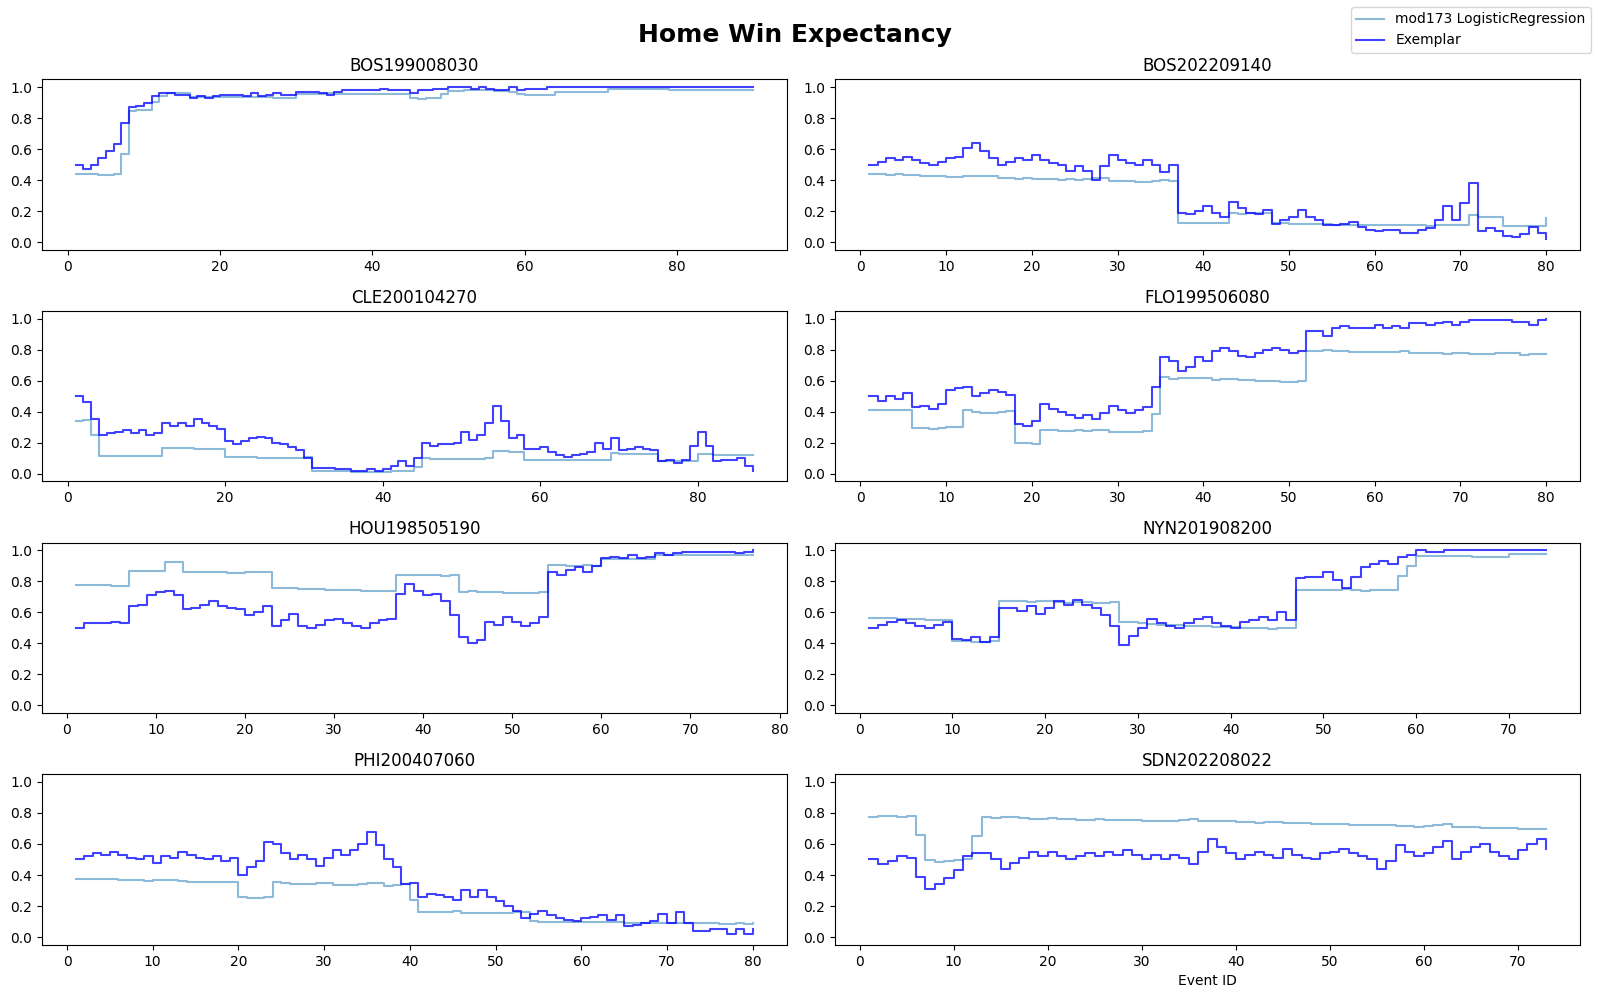

In [34]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 173

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 174

Logistic regression classifier with L2 regularization; $C=\frac{1}{\alpha}=0.07743$.

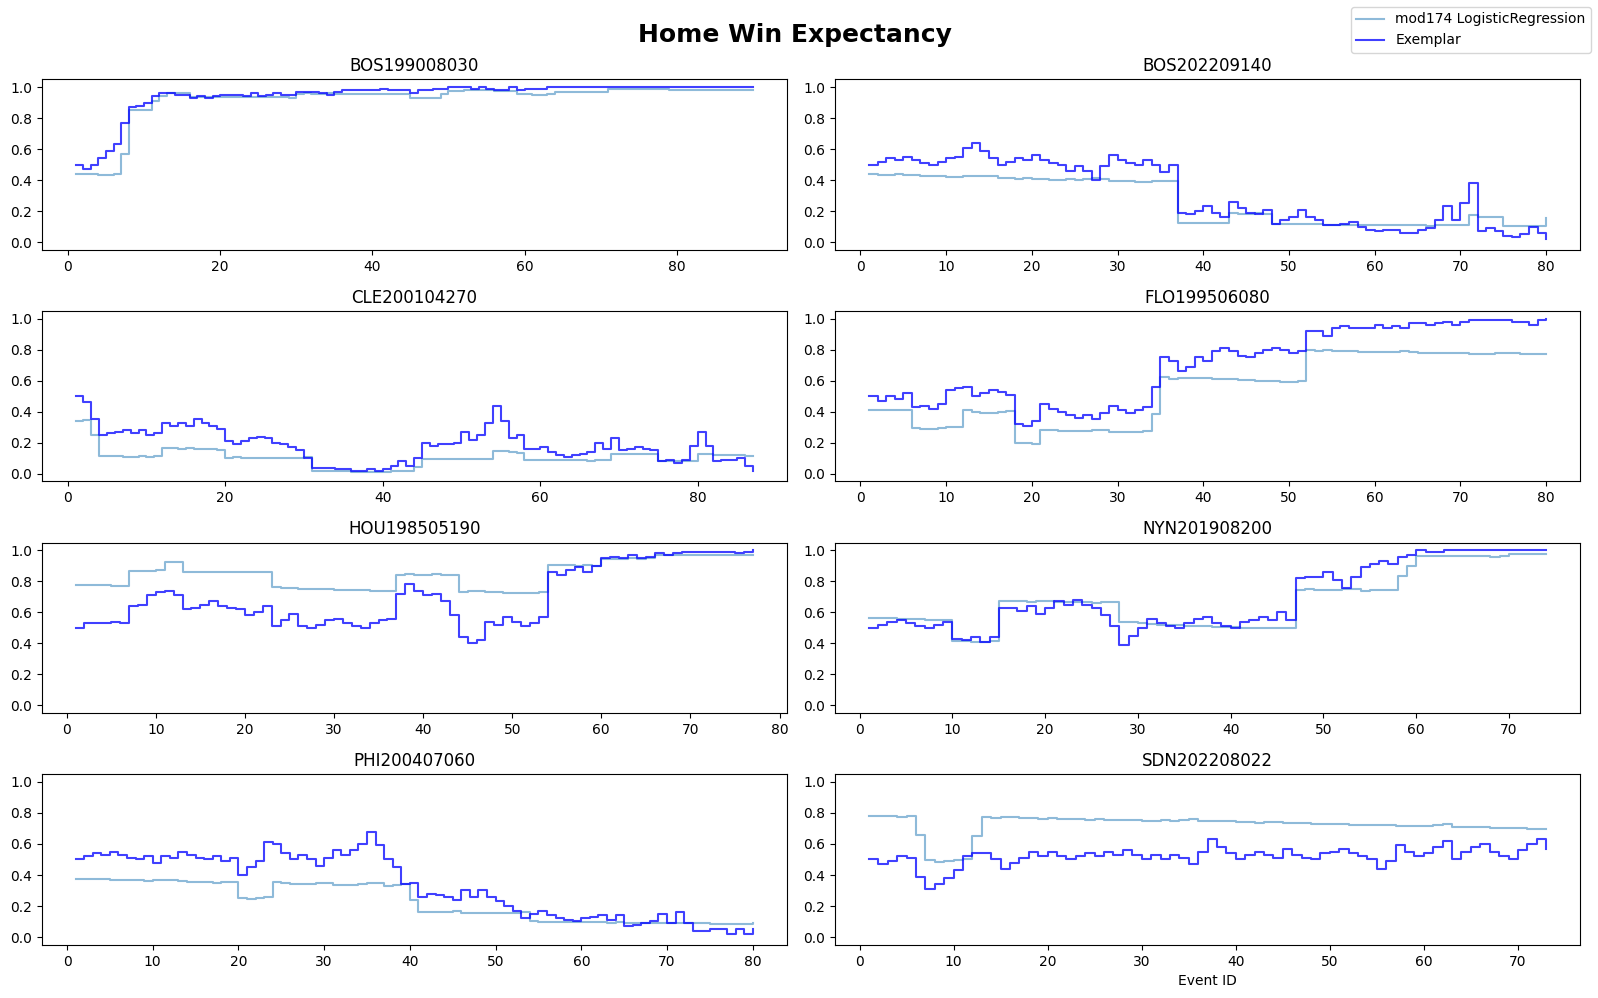

In [35]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 174

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 113

Naive Bayes classifier with $var_{smoothing}=0.667$.

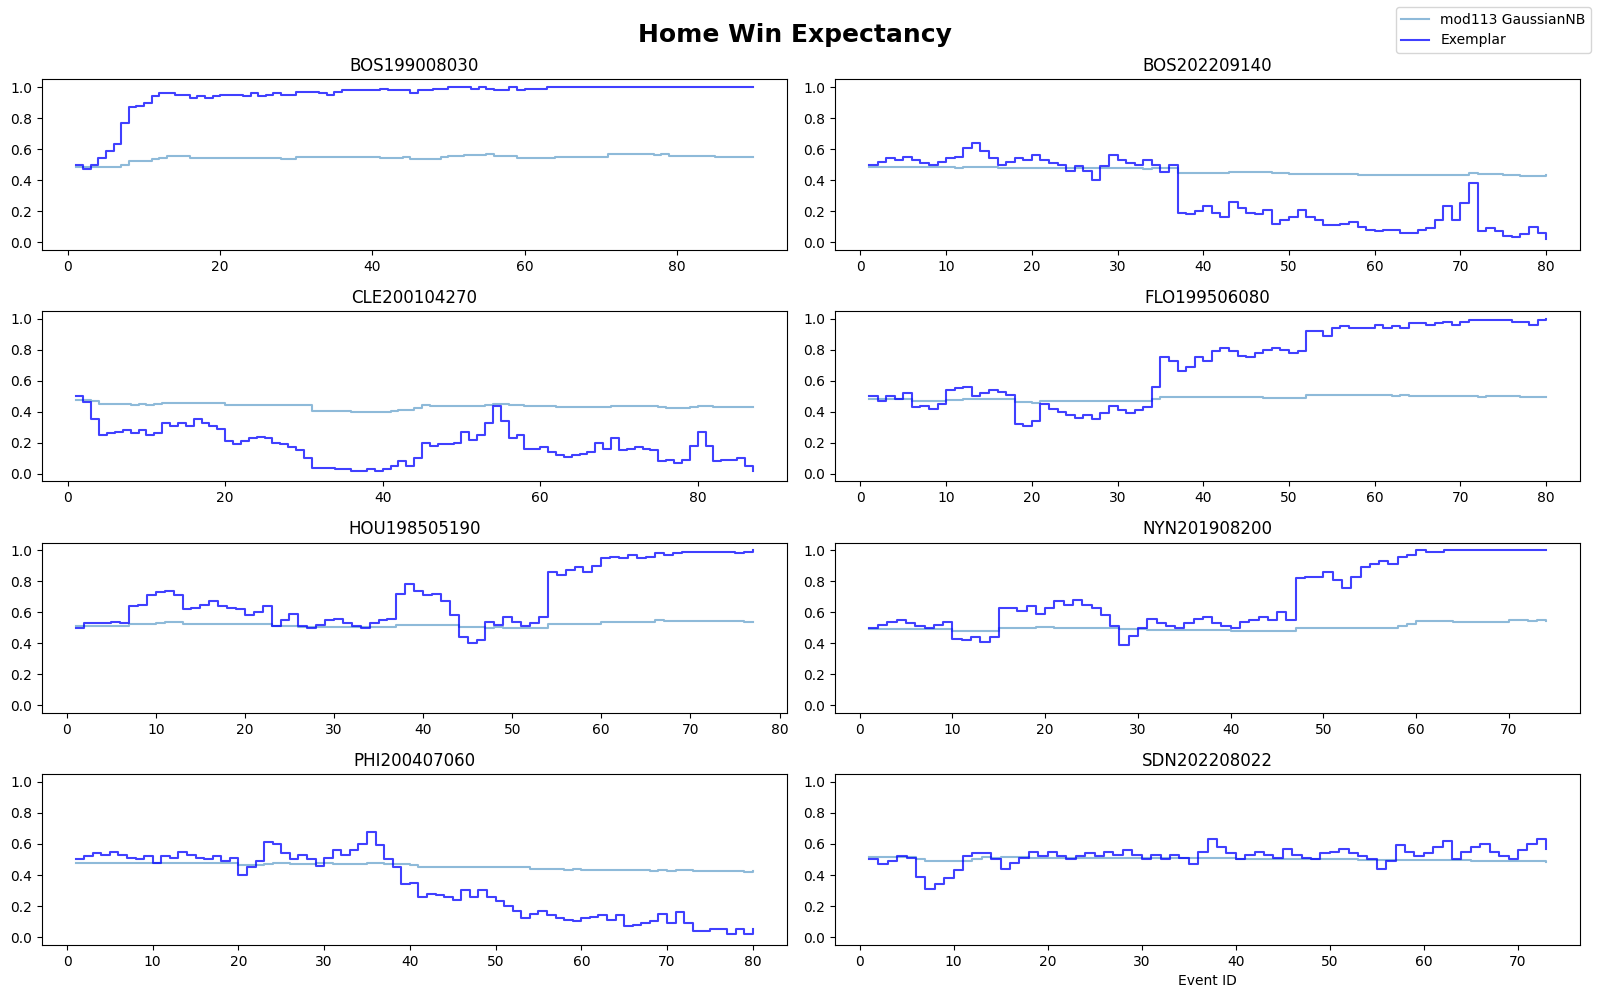

In [36]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 113

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 183

ANN using the identity activation function and 1 hidden layer with 16 nodes.

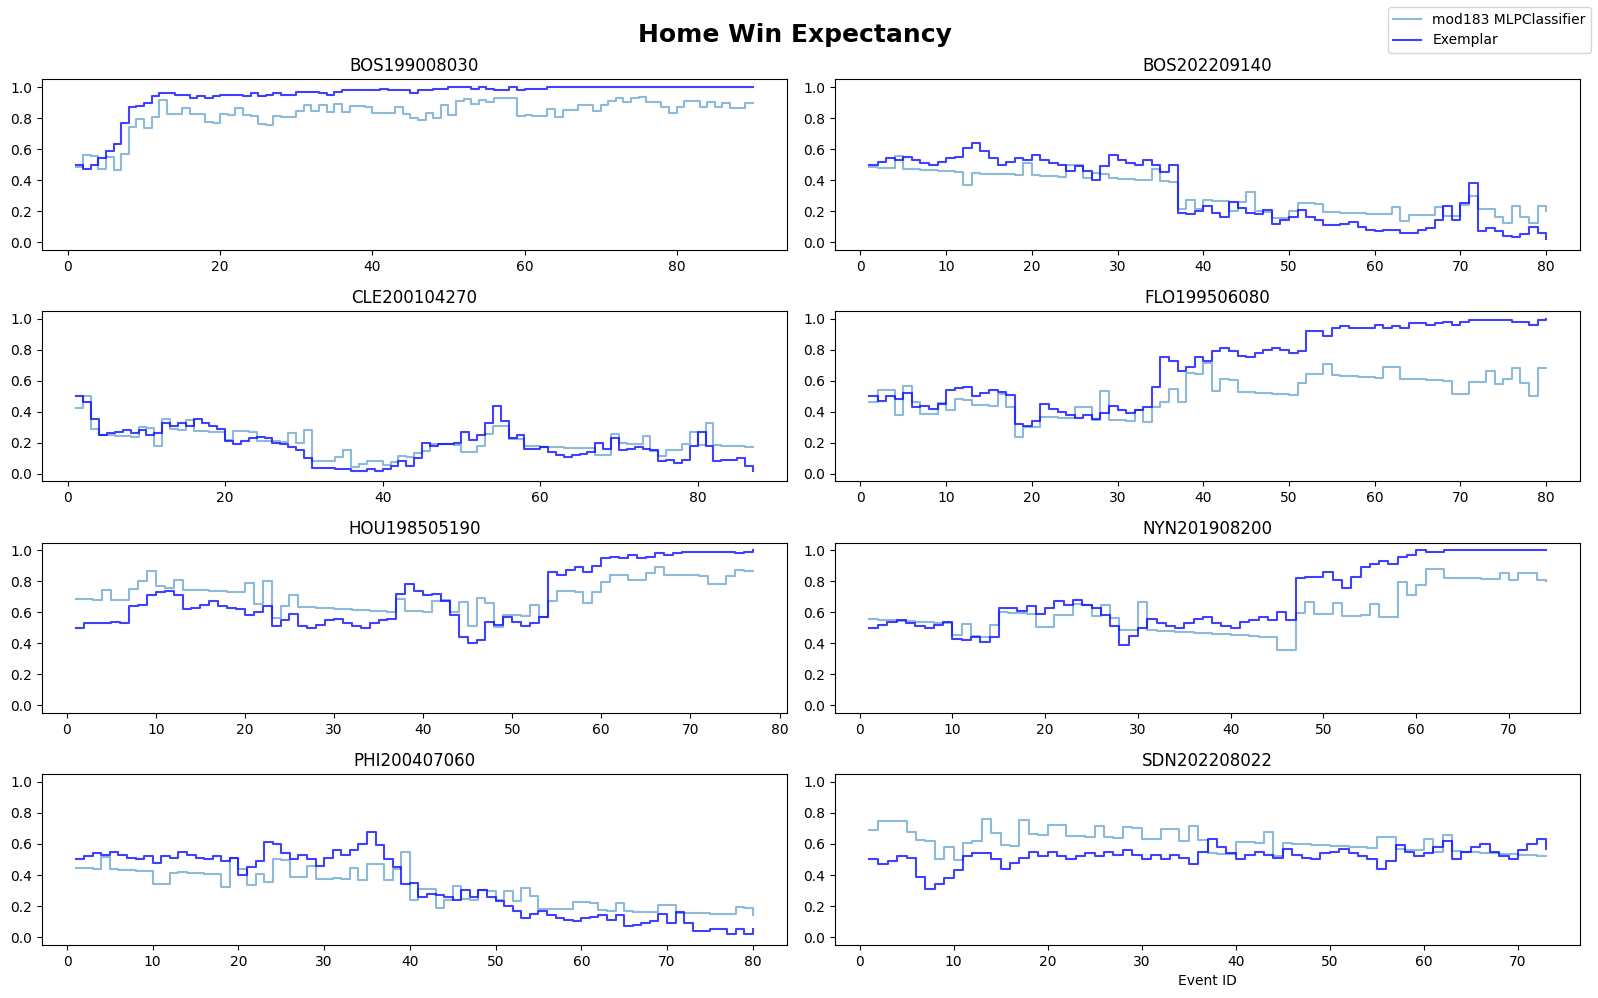

In [37]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 183

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 121

Decision tree classifier with minimum samples per terminal leaves=10 and maximum depth=7.

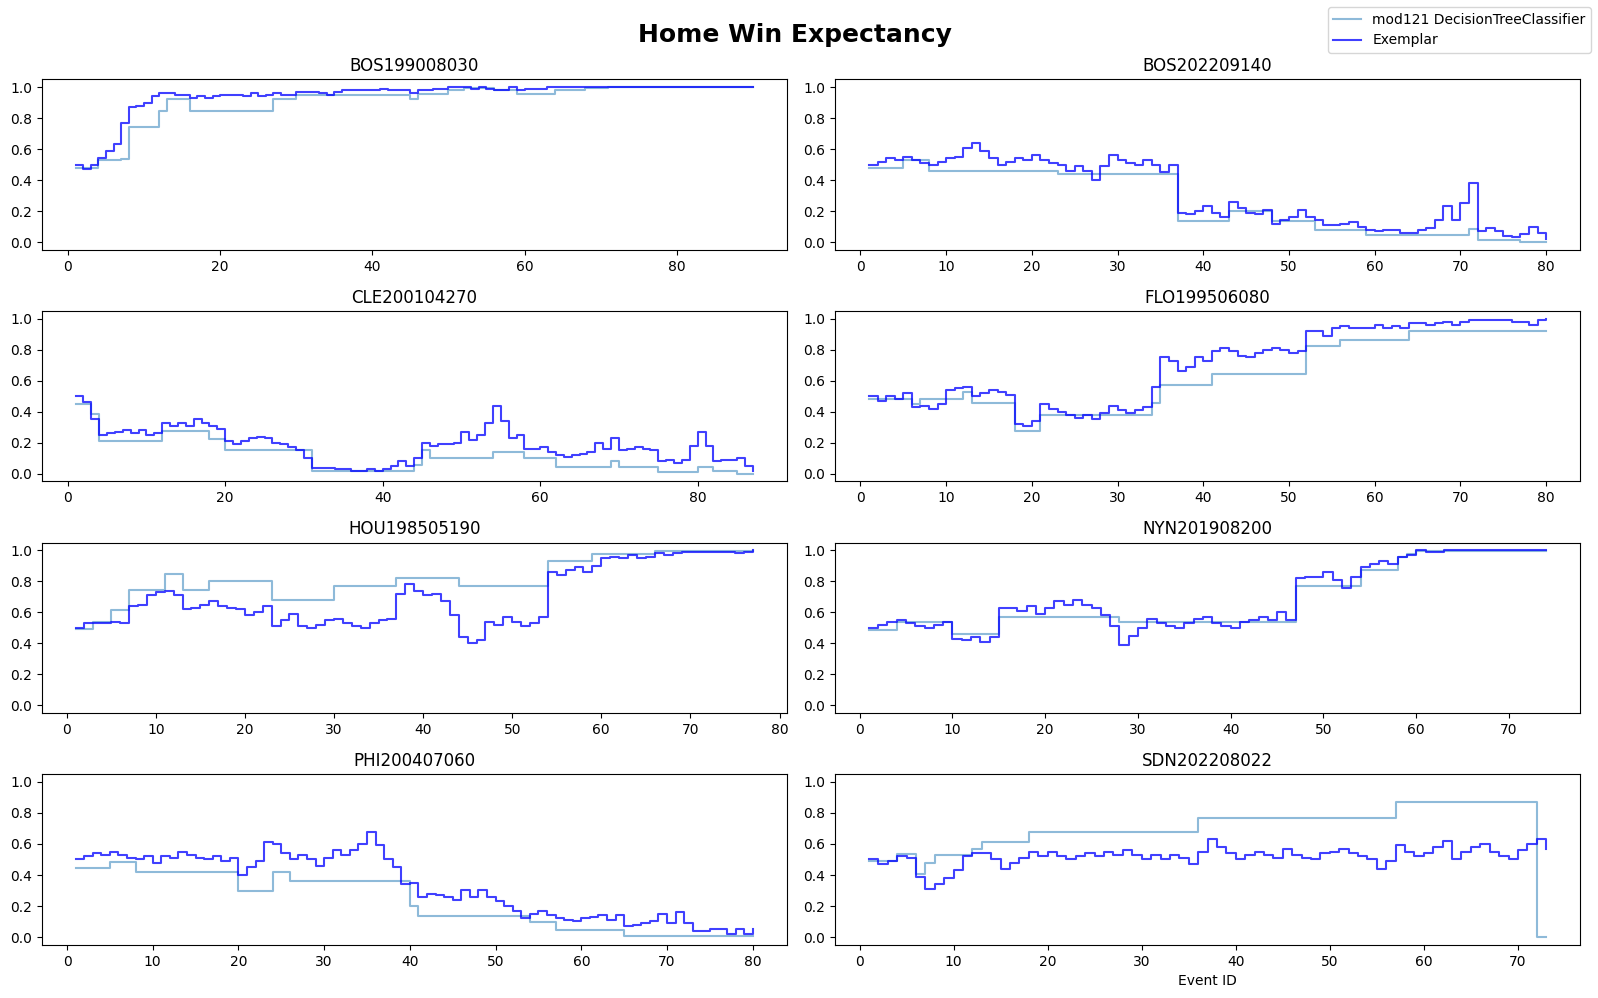

In [38]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 121

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

Model 189

ANN using the identity activation function and 2 hidden layers with 4 nodes per hidden layer.

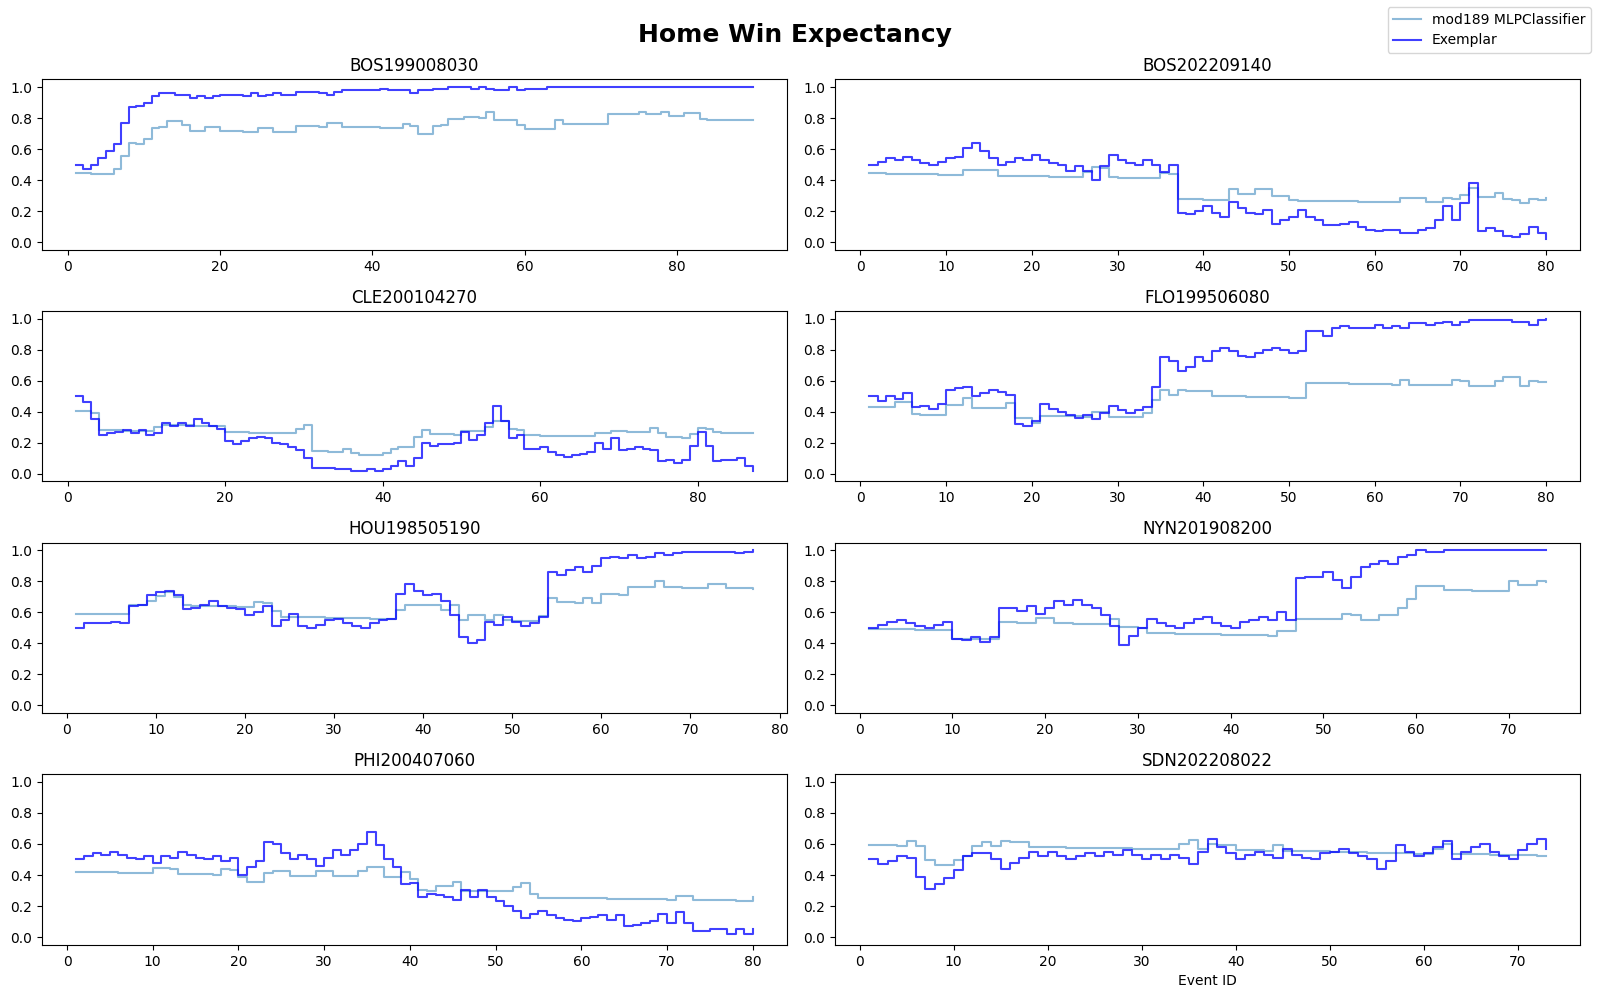

In [39]:
fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

mod_id = 189

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,2,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_ylim([-0.05,1.05])
    x = df_temp['event_id'].loc[df_temp['game_id']==game_id]
    # plot predictions
    for col in [f'yhat_m{mod_id}']:
        y = df_temp[col].loc[df_temp['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
    # add exemplar
    ax[i].step(x,df_temp['home_win_prob'].loc[df_temp['game_id']==game_id],
              where='post',
              alpha=0.75,
              c='blue')

ax[i].set_xlabel('Event ID')
leg_list = [f'mod{c} {mod_dict[c]["method"]}' for c in [mod_id]]
leg_list += ['Exemplar']
fig.legend(leg_list)

In [40]:
# clean house
del(ax, col, df_temp, fig, game_id, game_ids, i, leg_list)
del(x,y)
del(mod_id)

A visual inspection suggests that models 37, 70, and 129 are the best models moving forward. The initial and final win expectancies agree with the exemplars and the appear to correlate well despite their divergence in the middle innings.

#### 6.2.2 Aggregate WPA



Calculate WPA and assign the value to individual players using the process described by Baseball Reference.

In [41]:
for col, new_col in [[c,c.replace('yhat','wpa')] for c in df_slice.columns if 'yhat' in c]:
    # home team wpa
    df_slice[new_col] =  df_slice[col].shift(-1) - np.array(df_slice[col])
    # fix end of game entries
    m0 = df_slice['end_game']==1
    df_slice[new_col].loc[m0] = df_slice['home_win'].loc[m0] - df_slice[col].loc[m0]
    # flip sign for vis_team plate appearance
    m0 = df_slice['batting_team']==0
    df_slice[new_col].loc[m0] = -1*df_slice[new_col].loc[m0]

del(m0, col, new_col)

# assign resposibility to players
# most situations, off player responsible is the batter
df_slice['resp_off_pid'] = df_slice['result_batter_id']
# assign baserunning events to (lead) runner
br_events = ['balk',
             'caught stealing',
             'defensive indifference',
             'other advance',
             'passed ball',
             'pickoff',
             'stolen base',
             'wild pitch']
m0 = df_slice['event_type'].isin(br_events)
m0 = m0 & df_slice['batter_event']==0
m0 = m0 & (df_slice['sb_run_1b']==1)
m0 = m0 & (df_slice['sb_run_2b']==0)
m0 = m0 & (df_slice['sb_run_3b']==0)
df_slice['resp_off_pid'].loc[m0] = df_slice['run_1b'].loc[m0]

m0 = df_slice['event_type'].isin(br_events)
m0 = m0 & df_slice['batter_event']==0
m0 = m0 & (df_slice['sb_run_2b']==1)
m0 = m0 & (df_slice['sb_run_3b']==0)
df_slice['resp_off_pid'].loc[m0] = df_slice['run_2b'].loc[m0]

m0 = df_slice['event_type'].isin(br_events)
m0 = m0 & df_slice['batter_event']==0
m0 = m0 & (df_slice['sb_run_3b']==1)
df_slice['resp_off_pid'].loc[m0] = df_slice['run_3b'].loc[m0]

del(m0, br_events)

Plot distribution of WPA by event type. Events such as home runs or triples should be overwhelmingly positive. There is no conceivable scenario where a batting team records a home run, for instance, and the result is a negative WPA. Similarly, events such as caught stealing or pickoffs should skew negative for the batting team.


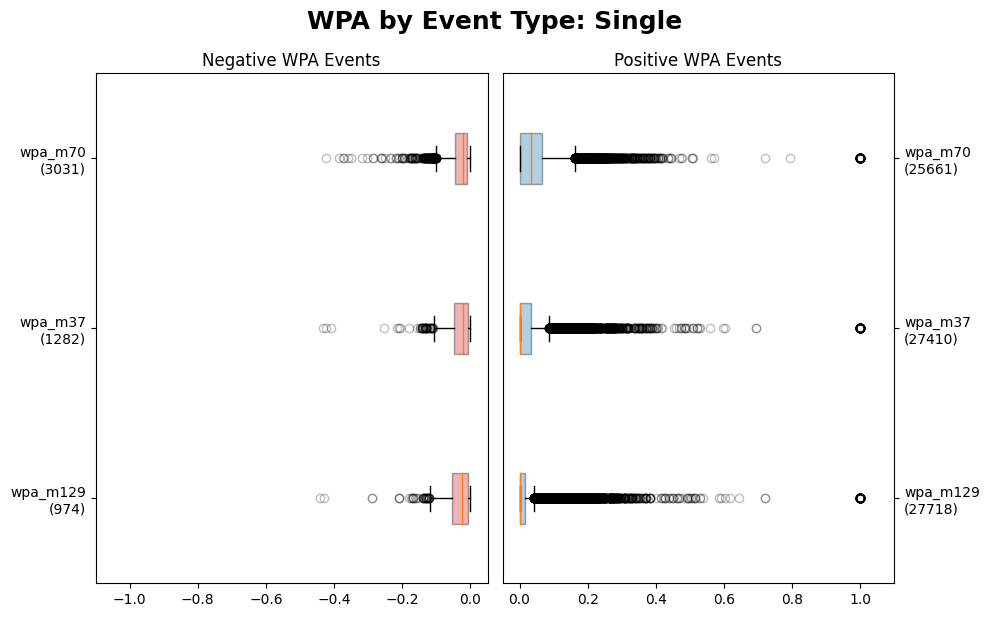

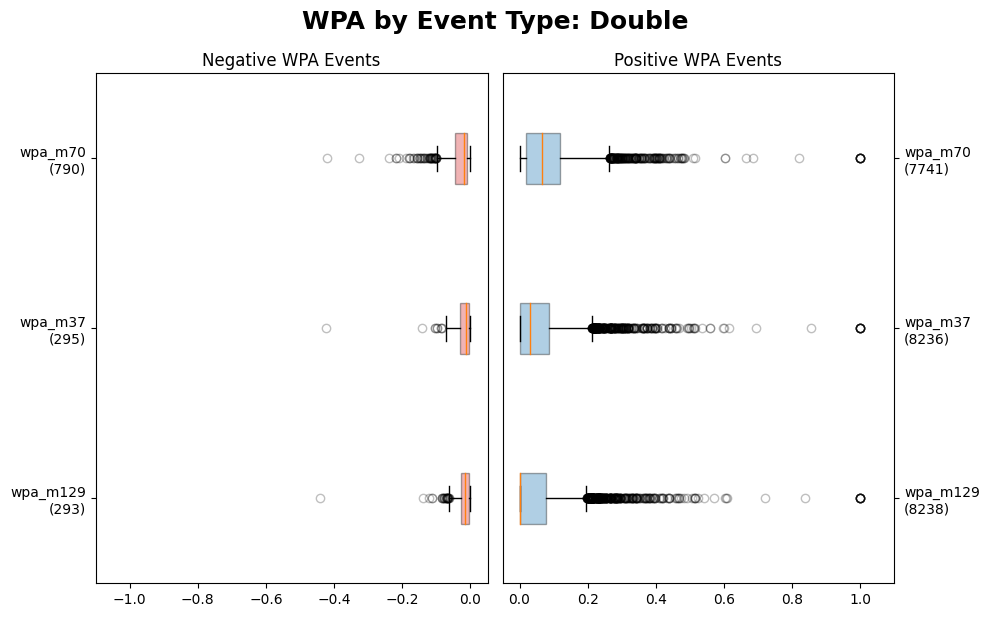

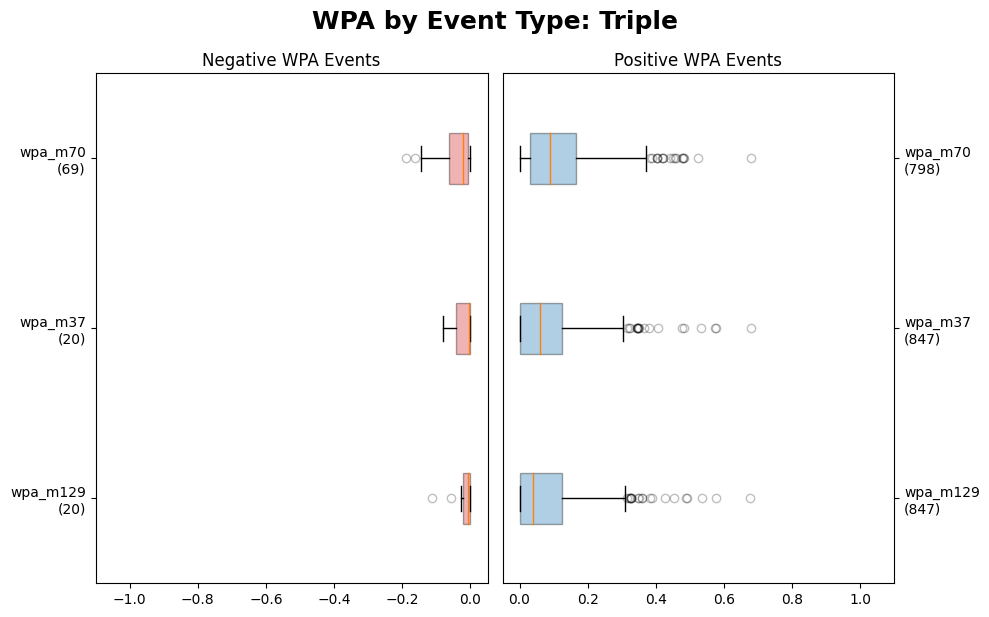

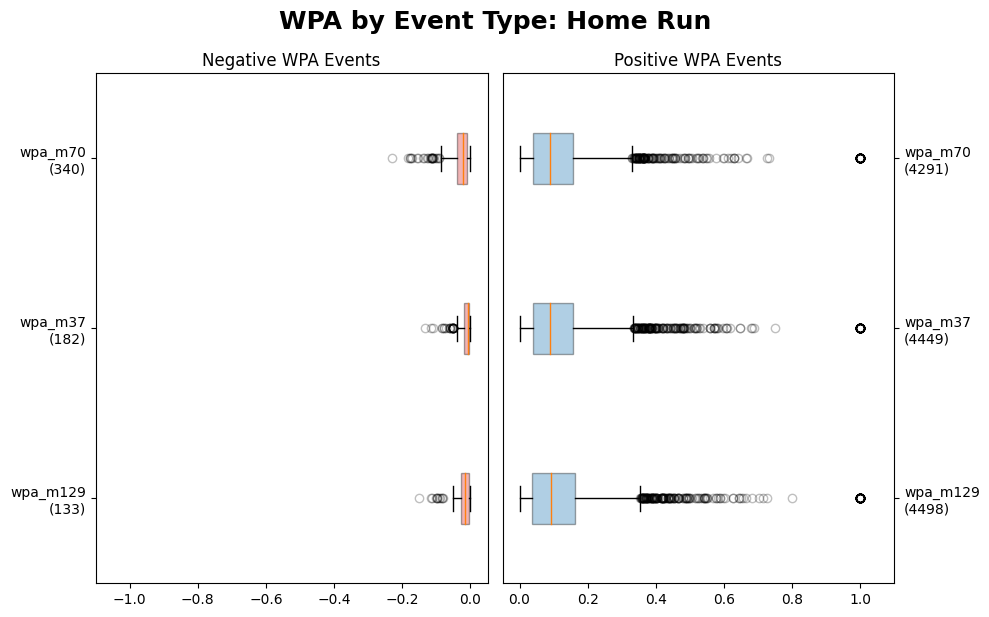

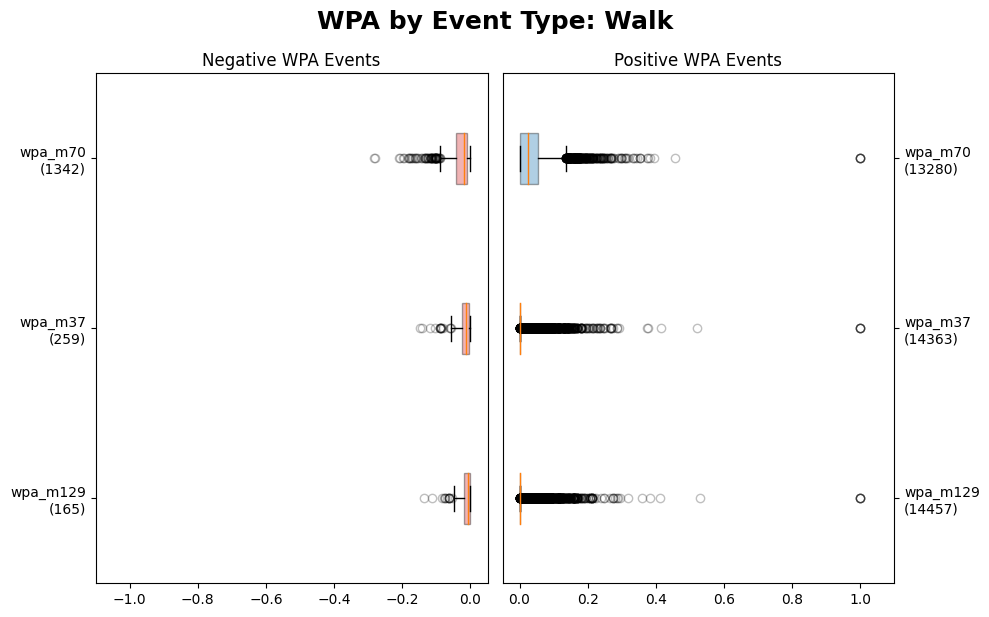

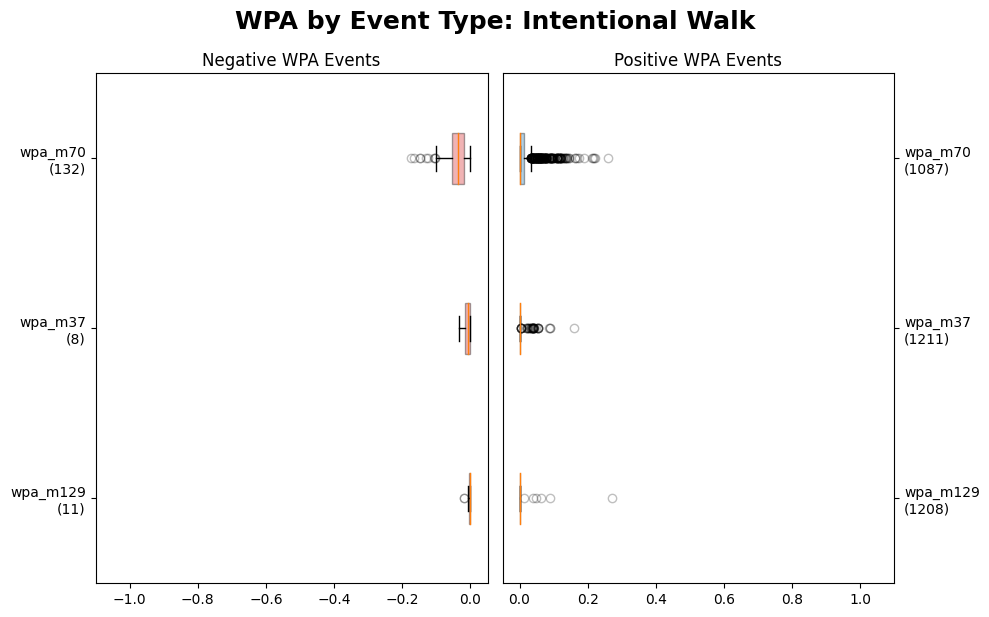

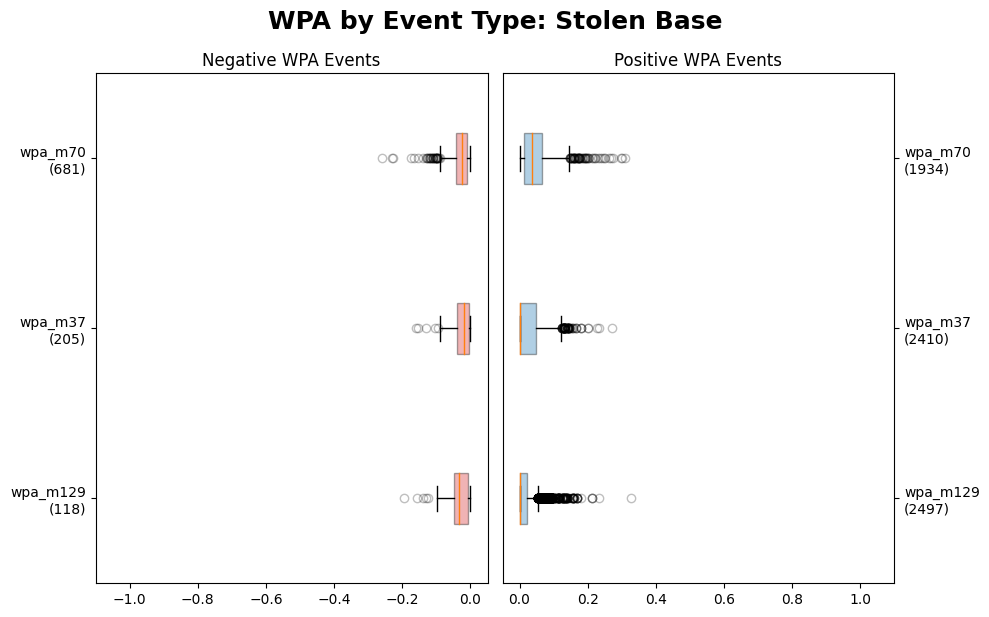

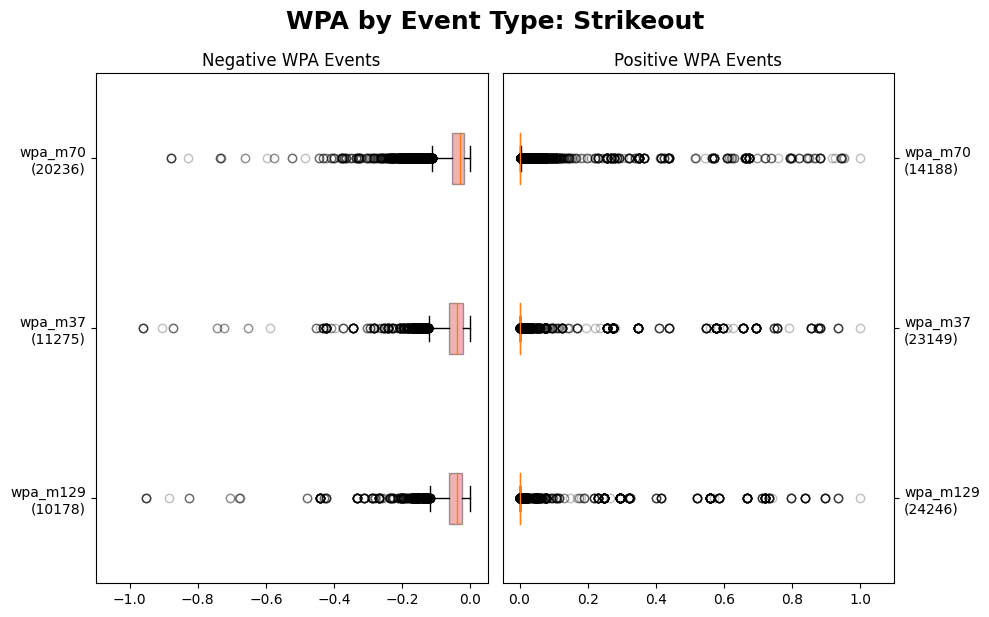

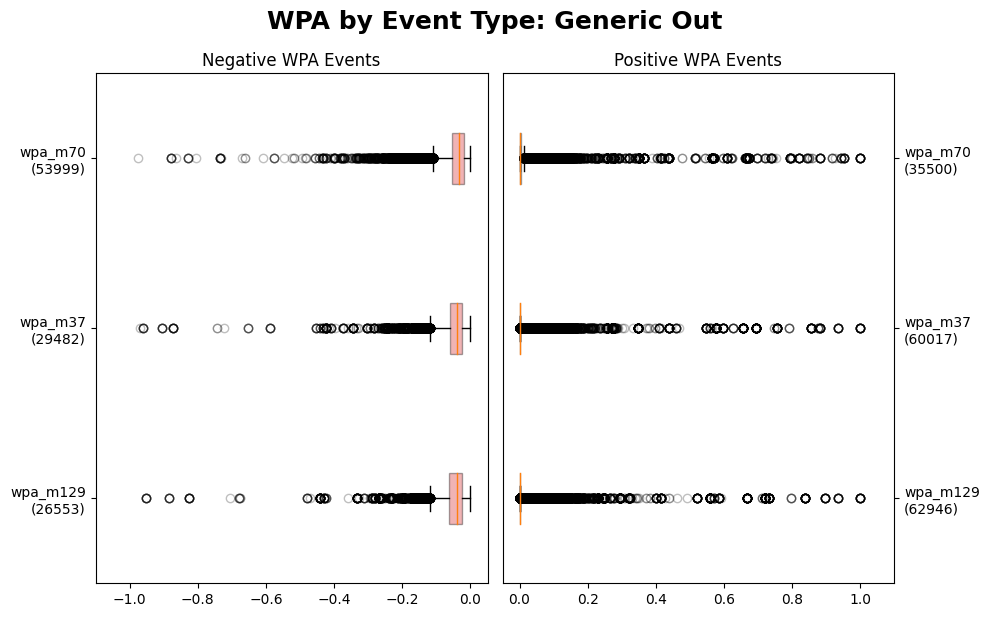

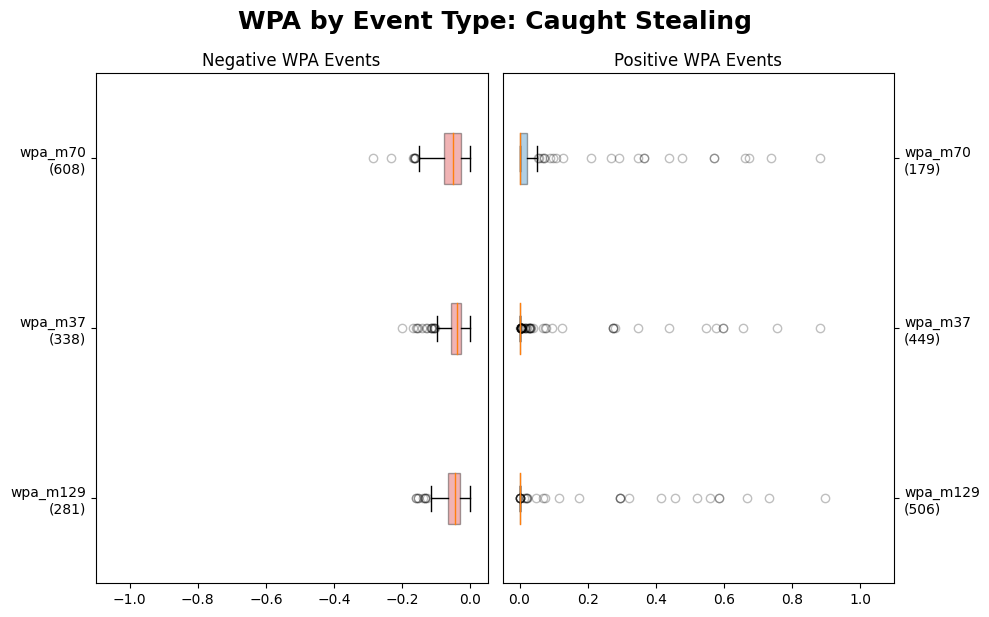

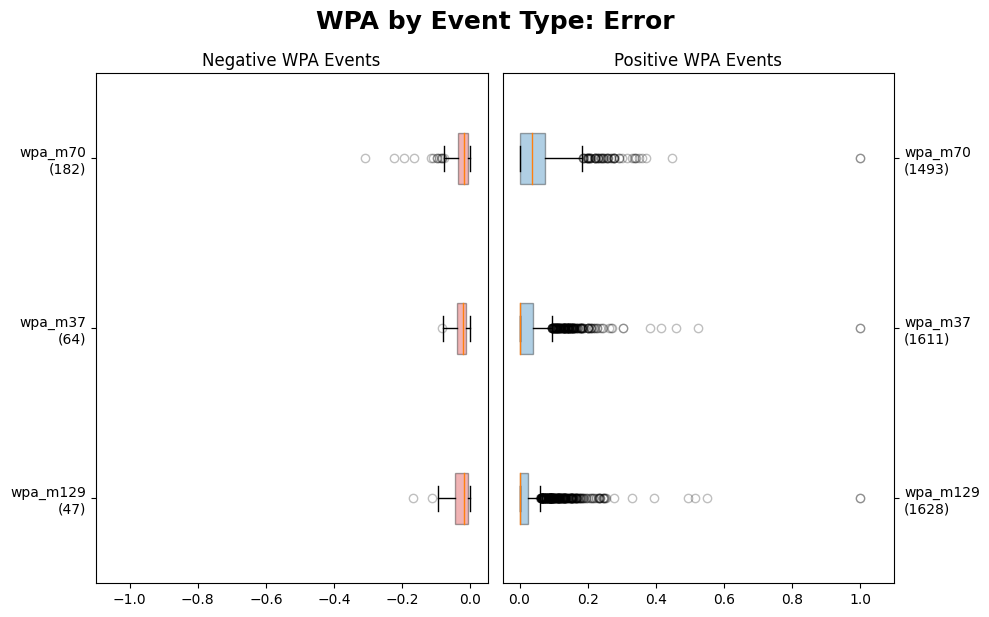

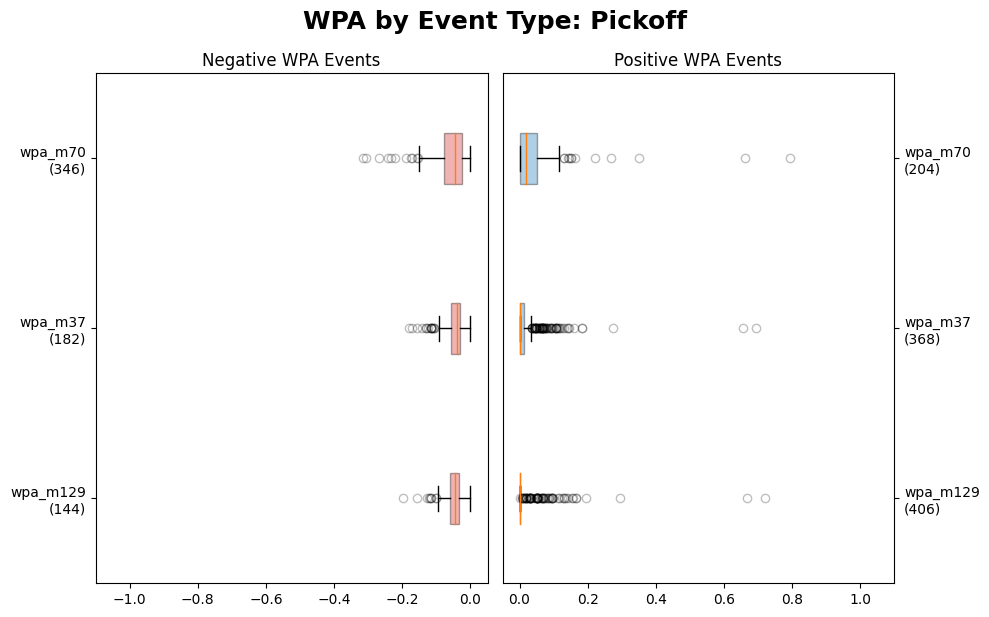

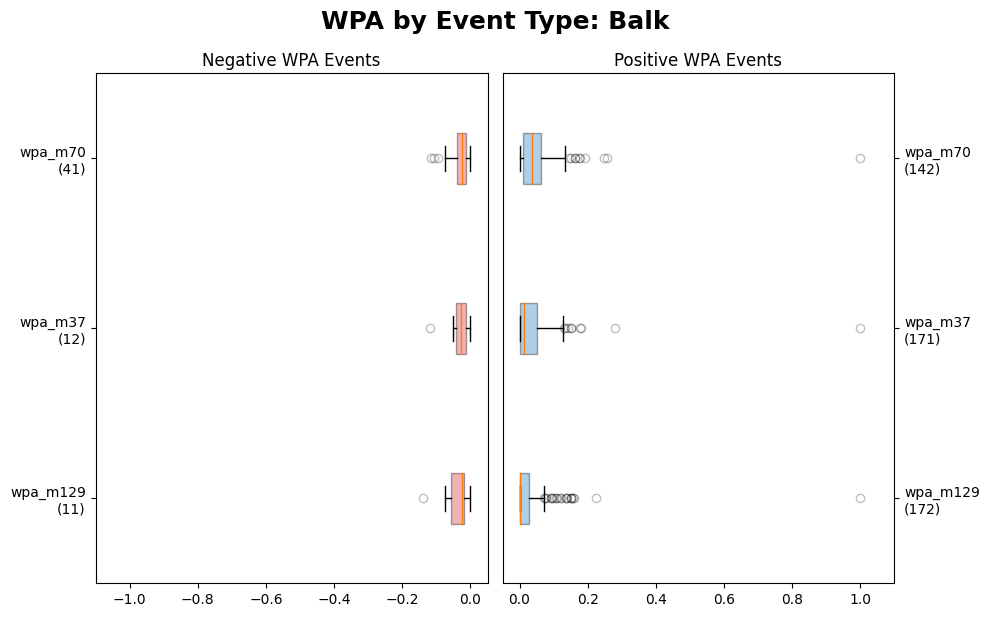

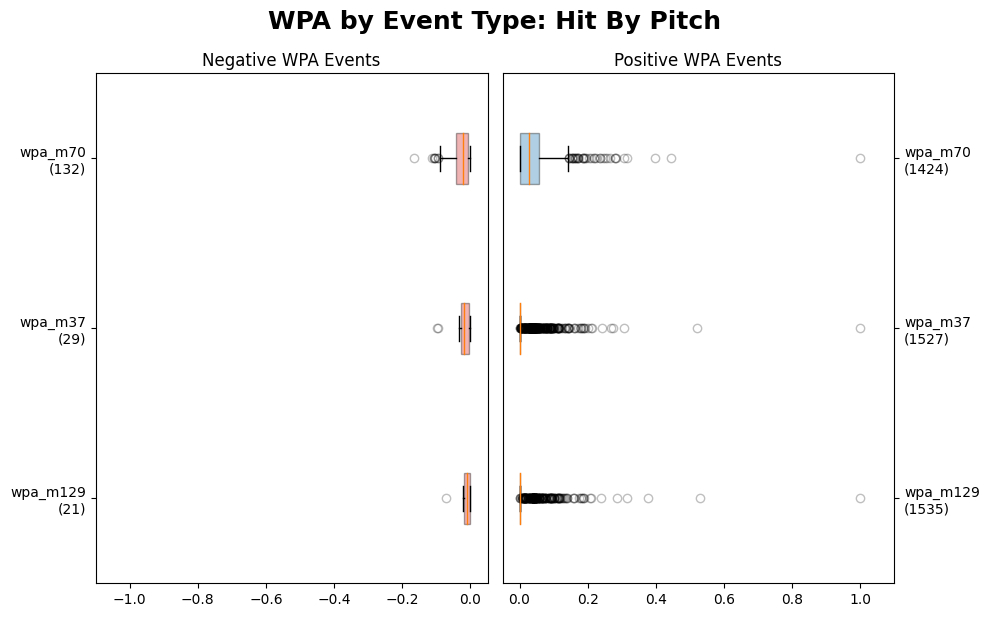

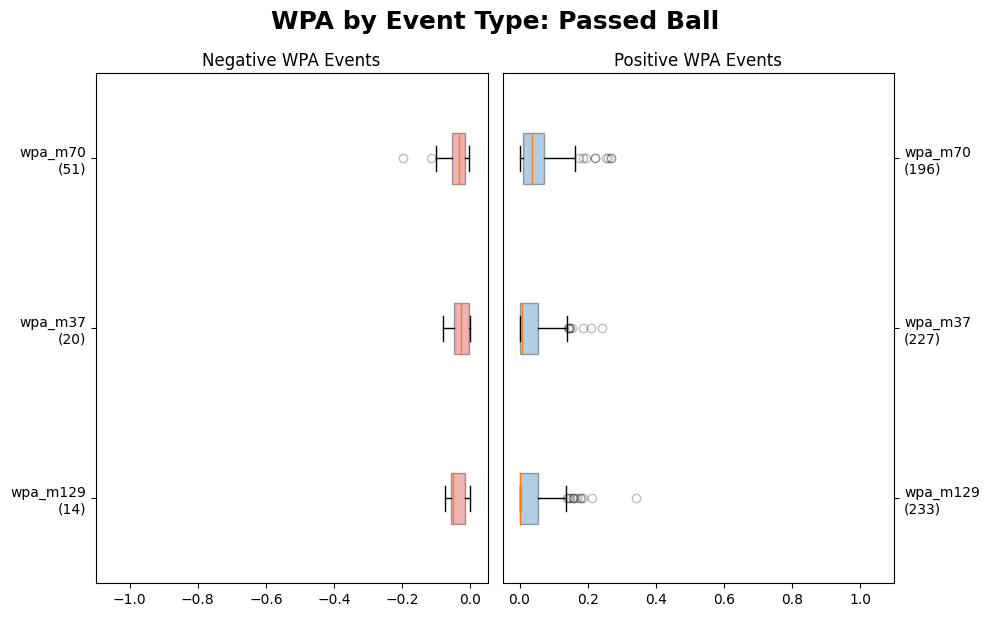

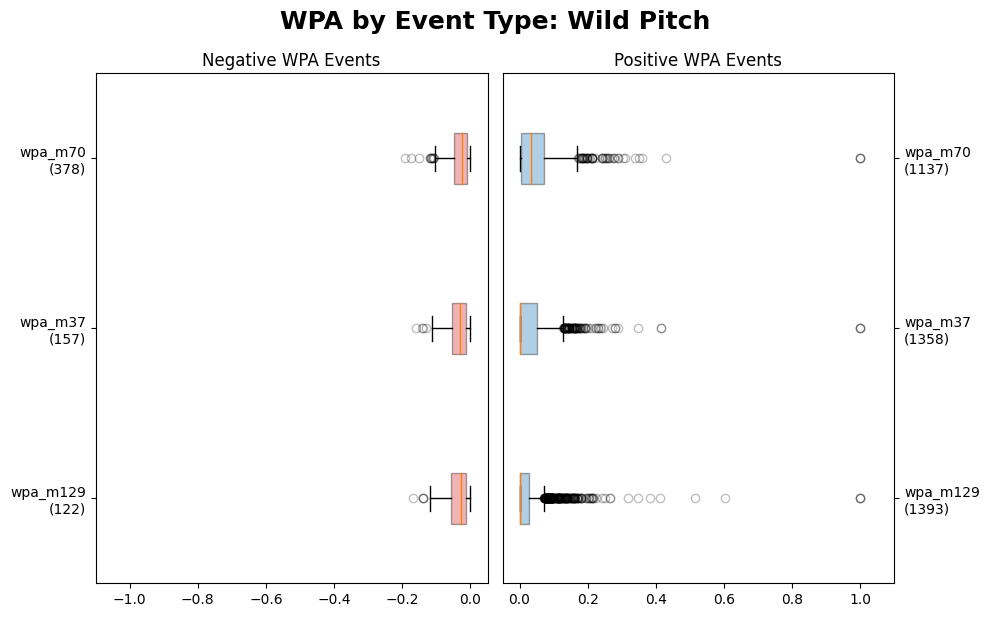

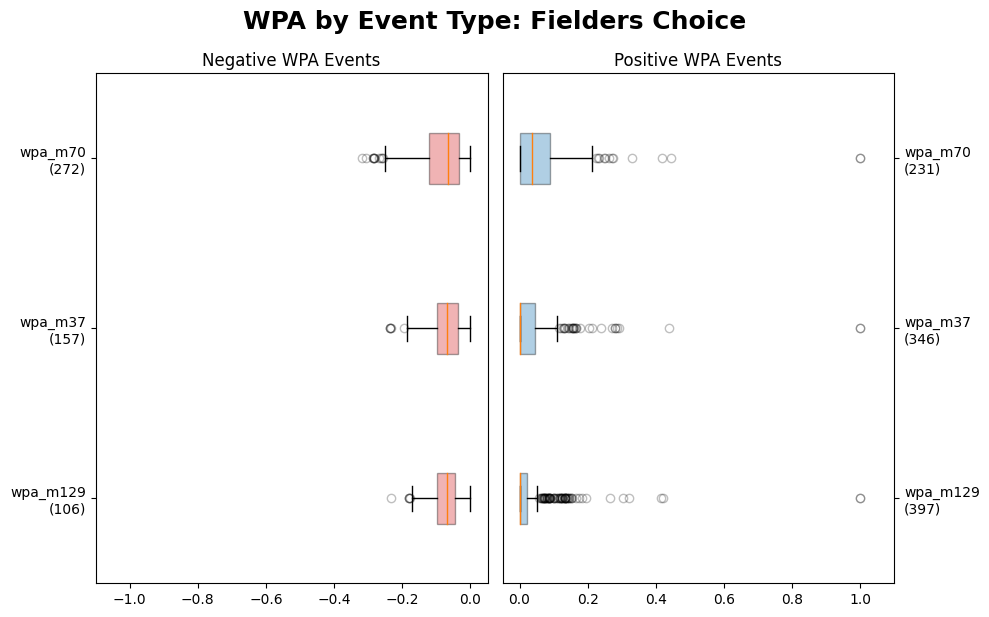

In [42]:
# plot WPA by event types (pos/neg)

event_types = ['single',
               'double',
               'triple',
               'home run',
               'walk',
               'intentional walk',
               'stolen base',
               'strikeout',
               'generic out',
               'caught stealing',
               'error',
               'pickoff',
               'balk',
               'hit by pitch',
               'passed ball',
               'wild pitch',
               'fielders choice']

models = ['wpa_m129','wpa_m37','wpa_m70']
# make plots
for et in event_types:
    plot_dict = {}

    for mod in models:
        m0 = (df_slice['event_type']==et)&(df_slice[mod]>=0)
        m1 = (df_slice['event_type']==et)&(df_slice[mod]<0)
        plot_dict[mod] = {'pos_wpa':df_slice[mod].loc[m0],
                        'pos_wpa_count':len(df_slice[mod].loc[m0]),
                        'neg_wpa':df_slice[mod].loc[m1],
                        'neg_wpa_count':len(df_slice[mod].loc[m1])}

    fig = plt.figure(figsize=(10,6.25), tight_layout=True)
    fig.suptitle(f'WPA by Event Type: {et.title()}', fontweight='bold', fontsize=18)
    ax0 = fig.add_subplot(1,2,1)
    ax0.set_xlim([-1.1,0.05])
    ax0.set_title('Negative WPA Events')
    bp0 = ax0.boxplot([plot_dict[m]['neg_wpa'] for m in models],
                     vert=False,
                     patch_artist=True)
    _ = [patch.set_alpha(0.35) for patch in bp0['boxes']]
    _ = [patch.set_facecolor('tab:red') for patch in bp0['boxes']]
    _ = [patch.set_edgecolor('black') for patch in bp0['boxes']]
    _ = [patch.set_alpha(0.25) for patch in bp0['fliers']]
    ax0.set_yticklabels([m+f'\n({plot_dict[m]["neg_wpa_count"]})' for m in models])
    ax0.invert_xaxis

    ax1 = fig.add_subplot(1,2,2)
    ax1.set_xlim([-0.05,1.1])
    ax1.set_title('Positive WPA Events')
    ax1.yaxis.tick_right()
    bp1 = ax1.boxplot([plot_dict[m]['pos_wpa'] for m in models],
                     vert=False,
                     patch_artist=True)
    _ = [patch.set_alpha(0.35) for patch in bp1['boxes']]
    _ = [patch.set_facecolor('tab:blue') for patch in bp1['boxes']]
    _ = [patch.set_edgecolor('black') for patch in bp1['boxes']]
    _ = [patch.set_alpha(0.25) for patch in bp1['fliers']]
    ax1.set_yticklabels([m+f'\n({plot_dict[m]["pos_wpa_count"]})' for m in models])


del(ax0, ax1, bp0,bp1, et, event_types, m0, m1)
del(fig)
del(mod, plot_dict, models)

Model 129 (decision tree classifier) has the best performance with respect to events that result in a positive WPA for the batting team. Model 70 (decision tree regressor) has the best performance predicting events that should result in a negative WPA for the batting team.


Next, we aggregate WPA for individual players and compare the results to the Baseball Reference leaders for the 2010 season.

In [43]:
cols = [c for c in df_slice.columns if 'wpa_' in c]

df_grp = df_slice[['resp_off_pid']+cols].loc[df_slice['season']==2010].groupby(['resp_off_pid']).sum()
df_grp = df_grp.reset_index()

bbref_ex02 = bbref_ex02.merge(df_grp,
                              how='inner',
                              left_on=['id'],
                              right_on=['resp_off_pid'])

In [44]:
bbref_ex02[['Name','id','Tm','WPA','wpa_m37','wpa_m70','wpa_m129','wpa_m189']].head(25)

,Name,id,Tm,WPA,wpa_m37,wpa_m70,wpa_m129,wpa_m189
0,Miguel Cabrera,cabrm001,DET,7.5,6.664625,5.560694,6.303437,5.429035
1,Joey Votto,vottj001,CIN,6.9,4.803579,6.168220,5.105409,4.336575
2,Josh Hamilton,hamij003,TEX,6.2,5.472453,5.111147,5.635894,3.136964
3,Albert Pujols,pujoa001,STL,5.3,4.589609,6.005304,4.304640,6.339130
4,Jason Heyward,heywj001,ATL,4.8,12.257798,10.496023,10.818978,2.746631
5,Shin-Soo Choo,choos001,CLE,4.7,4.666978,4.063888,3.351691,1.552667
6,AdriÃ¡n GonzÃ¡lez,gonza003,SDP,4.7,7.671059,8.888156,7.883239,4.284924
7,Nelson Cruz,cruzn002,TEX,4.2,6.455209,4.710355,5.988398,5.176891
8,JosÃ© Bautista,bautj002,TOR,4.1,3.312289,4.427628,2.119689,4.324051
9,Robinson CanÃ³,canor001,NYY,4.1,0.544773,4.805552,0.101896,1.913411


Relative to Baseball Reference's WPA, the final three models generally perform well identifying the league leaders. The values and rankings are not an exact match, and we address this issue in further detail in Section 7.

Finally, we look at the mean-squared error between the aggregated model predictions and Baseball Reference leaders table for the 2010 season.

In [45]:
_ = [print(f'MSE {c}: {(25-len(c))*" "} {np.mean((bbref_ex02["WPA"] - bbref_ex02[c])**2)}') for c in bbref_ex02.columns if 'wpa_m' in c]

MSE wpa_m1:                     3.9167833263923444
MSE wpa_m37:                    1.8336049842015334
MSE wpa_m70:                    1.4975323975820154
MSE wpa_m103:                   6.91273945003461
MSE wpa_m11:                    3.9163957197132238
MSE wpa_m13:                    3.8781701762815235
MSE wpa_m17:                    3.916720643046117
MSE wpa_m129:                   1.6917827184773544
MSE wpa_m107:                   4.403234689261121
MSE wpa_m173:                   6.2160233442465715
MSE wpa_m174:                   6.282875995954615
MSE wpa_m113:                   4.635539759239098
MSE wpa_m183:                   2.37909150828987
MSE wpa_m121:                   4.3553834547103705
MSE wpa_m189:                   0.8255772053972484


Model 189 (ANN classifier) has the lowest MSE, but showed significant divergence on the individual game plots in Section 6.2.1.2, so we excluded it from consideration. Models 70 and 129 are ranked second and third, suggesting that decision trees are the best candidate for further development.


## 7. Conclusions

The purpose of this project was to determine if it is feasible to produce a model for WE and WPA that simplifies the procedures used by Baseball Reference. Specifically, Baseball Reference describes a method for simulating various run scoring environments for both parks and seasons. We eliminated that step and applied factors based on the mean combined scores for each park and season (1920-2022). We surveyed a series of algorithms and found that decision trees, regressors and classifiers, are the best candidates for further investigation.

### 7.1 Strengths

The best models appear to positively correlate to the Baseball Reference figures. The process for estimating park/season factors is simpler in concept and practice.

### 7.2 Weaknesses

The best models appear to be more volatile, i.e., the change in WE in consecutive events tend to be greater in the model predictions than the Baseball Reference data. This causes the models to significantly diverge from the Baseball Reference figures in the middle innings. Furthermore, the fitted models are more sensitive to rare events. A team overcoming a large deficit, for example, will alter the *a priori* probabilities that a misspecified model will not account for.

### 7.3 Improvements

We can improve the results by exploring the data in more depth before fitting a model. The *a priori* win expectancies are calculated by naively aggregating wins and losses for a given base-out situation. As mentioned above, a rare event can alter these win expectancies and skew the results. To address this, we will investigate applying a smoothing procedure (LOESS/LOWESS, for example) to the win expectancies.

We have identified decision trees as the best candidates for further development. We can improve the results found here by performing a more exhaustive cross-validation procedure or pruning the tree, which we did not do here as a concession to time and computing resources.



